### Import and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy.optimize

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Sparse Autoencoder Implementation

In [2]:
class SparseAutoencoder(nn.Module):
    """
    Key features:
    - KL divergence sparsity penalty
    - L2 weight decay
    """

    def __init__(self, input_dim=784, hidden_dim=256, sparsity_param=0.05, beta=3.0, lamda=0.0001):
        """
        Args:
            input_dim: Input dimension (784 for MNIST)
            hidden_dim: Number of hidden units
            sparsity_param: Target average activation (rho)
            beta: Weight of sparsity penalty term
            lamda: Weight decay parameter
        """
        super(SparseAutoencoder, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.sparsity_param = sparsity_param
        self.beta = beta
        self.lamda = lamda

        # Encoder parameters
        self.W1 = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(hidden_dim))

        # Decoder parameters (tied weights - W2 = W1^T)
        self.b2 = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        """Encoder: x -> hidden activations"""
        z = torch.mm(x, self.W1.t()) + self.b1
        a = torch.sigmoid(z)  # Activations in [0,1]
        return a

    def decode(self, a):
        """Decoder: hidden activations -> reconstruction"""
        # Use tied weights: W2 = W1^T
        z = torch.mm(a, self.W1) + self.b2
        x_recon = torch.sigmoid(z)
        return x_recon

    def forward(self, x):
        """Forward pass"""
        # Flatten input if needed
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        self.hidden_activations = self.encode(x)
        self.reconstructed = self.decode(self.hidden_activations)

        return self.reconstructed

    def kl_divergence(self, rho_hat):
        """
        KL divergence between target sparsity (rho) and actual average activations (rho_hat)
        KL(rho || rho_hat) = rho * log(rho/rho_hat) + (1-rho) * log((1-rho)/(1-rho_hat))
        """
        rho = self.sparsity_param
        kl = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        return kl.sum()

    def loss_function(self, x, x_recon):
        """
        Sparse autoencoder loss =
        Reconstruction loss + beta * Sparsity penalty + lambda * Weight decay
        """
        batch_size = x.size(0)

        # 1. Reconstruction loss (mean squared error)
        recon_loss = F.mse_loss(x_recon, x, reduction='sum') / batch_size

        # 2. Sparsity penalty
        rho_hat = torch.mean(self.hidden_activations, dim=0)  # Average over batch
        sparsity_penalty = self.beta * self.kl_divergence(rho_hat)

        # 3. Weight decay (L2 regularization)
        weight_decay = 0.5 * self.lamda * torch.sum(self.W1 ** 2)

        total_loss = recon_loss + sparsity_penalty + weight_decay

        return total_loss, recon_loss, sparsity_penalty, weight_decay

    def get_sparsity_statistics(self):
        """Get statistics about hidden unit activations"""
        with torch.no_grad():
            avg_activations = torch.mean(self.hidden_activations, dim=0)
            sparsity_level = torch.mean((avg_activations < 0.01).float())  # % of very inactive neurons
            return {
                'avg_activation': torch.mean(avg_activations).item(),
                'min_activation': torch.min(avg_activations).item(),
                'max_activation': torch.max(avg_activations).item(),
                'sparsity_level': sparsity_level.item(),  # % neurons with < 0.01 activation
                'target_sparsity': self.sparsity_param
            }

### Training function

In [6]:
def train_sparse_autoencoder(model, train_loader, test_loader, epochs=100, learning_rate=0.001):
    """
    Training procedure for sparse autoencoder
    """
    optimizer = optim.Adam([model.W1, model.b1, model.b2], lr=learning_rate)

    train_losses = []
    test_losses = []
    sparsity_stats = []

    model.to(device)

    print("Starting Sparse Autoencoder Training...")
    print("=" * 60)
    print(f"Target sparsity: {model.sparsity_param}")
    print(f"Sparsity weight (beta): {model.beta}")
    print(f"Weight decay (lambda): {model.lamda}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_total_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_sparsity_loss = 0.0
        epoch_weight_decay = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device).view(data.size(0), -1)

            optimizer.zero_grad()

            # Forward pass
            reconstructed = model(data)

            # Calculate loss
            total_loss, recon_loss, sparsity_loss, weight_decay = model.loss_function(data, reconstructed)

            # Backward pass
            total_loss.backward()
            optimizer.step()

            # Accumulate losses
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_sparsity_loss += sparsity_loss.item()
            epoch_weight_decay += weight_decay.item()

            pbar.set_postfix({
                'Total': f'{total_loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'Sparse': f'{sparsity_loss.item():.4f}'
            })

        # Calculate average losses
        avg_total_loss = epoch_total_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_sparsity_loss = epoch_sparsity_loss / len(train_loader)
        avg_weight_decay = epoch_weight_decay / len(train_loader)

        train_losses.append(avg_total_loss)

        # Get sparsity statistics
        stats = model.get_sparsity_statistics()
        sparsity_stats.append(stats)

        # Validation
        avg_test_loss = evaluate_sparse_ae(model, test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}:')
        print(f'  Total Loss: {avg_total_loss:.4f} | Test Loss: {avg_test_loss:.4f}')
        print(f'  Recon: {avg_recon_loss:.4f} | Sparse: {avg_sparsity_loss:.4f} | WD: {avg_weight_decay:.4f}')
        print(f'  Avg Activation: {stats["avg_activation"]:.4f} (target: {model.sparsity_param})')
        print(f'  Sparsity Level: {stats["sparsity_level"]:.2%} neurons < 0.01 activation')
        print()

    return train_losses, test_losses, sparsity_stats

def evaluate_sparse_ae(model, test_loader):
    """Evaluate sparse autoencoder on test data"""
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device).view(data.size(0), -1)
            reconstructed = model(data)
            loss, _, _, _ = model.loss_function(data, reconstructed)
            test_loss += loss.item()

    return test_loss / len(test_loader)

### Visualize function

In [4]:
def visualize_learned_features(model, title="Sparse Autoencoder Learned Features"):
    """
    Visualize the weights of the first layer (like in the paper)
    Each row of W1 represents a feature detector
    """
    W1 = model.W1.detach().cpu().numpy()

    # Normalize for visualization
    W1 = (W1 - W1.min()) / (W1.max() - W1.min())

    # Plot features in a grid
    n_features = model.hidden_dim
    grid_size = int(np.ceil(np.sqrt(n_features)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < n_features:
            feature = W1[i].reshape(28, 28)
            ax.imshow(feature, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_training_progress(train_losses, test_losses, sparsity_stats):
    """Plot training progress and sparsity statistics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', linewidth=2)
    ax1.plot(test_losses, label='Test Loss', linewidth=2)
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot average activations
    avg_activations = [s['avg_activation'] for s in sparsity_stats]
    ax2.plot(avg_activations, linewidth=2, color='red')
    ax2.axhline(y=sparsity_stats[0]['target_sparsity'], color='black', linestyle='--',
                label=f'Target: {sparsity_stats[0]["target_sparsity"]}')
    ax2.set_title('Average Hidden Unit Activation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Average Activation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot sparsity level
    sparsity_levels = [s['sparsity_level'] for s in sparsity_stats]
    ax3.plot(sparsity_levels, linewidth=2, color='green')
    ax3.set_title('Percentage of Inactive Neurons (< 0.01 activation)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Sparsity Level')
    ax3.grid(True, alpha=0.3)

    # Plot activation range
    min_activations = [s['min_activation'] for s in sparsity_stats]
    max_activations = [s['max_activation'] for s in sparsity_stats]
    ax4.plot(min_activations, label='Min Activation', linewidth=2, alpha=0.7)
    ax4.plot(max_activations, label='Max Activation', linewidth=2, alpha=0.7)
    ax4.set_title('Activation Range')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Activation Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def compare_activations_dense_vs_sparse(dense_model, sparse_model, test_loader):
    """Compare activation patterns between dense and sparse autoencoders"""
    dense_model.eval()
    sparse_model.eval()

    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)

        # Get activations
        dense_activations = dense_model.encode(data.view(data.size(0), -1))
        sparse_activations = sparse_model.encode(data.view(data.size(0), -1))

        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Dense autoencoder activations
        im1 = ax1.imshow(dense_activations.cpu().numpy(), aspect='auto', cmap='viridis')
        ax1.set_title('Dense Autoencoder Activations')
        ax1.set_xlabel('Hidden Units')
        ax1.set_ylabel('Samples')
        plt.colorbar(im1, ax=ax1)

        # Sparse autoencoder activations
        im2 = ax2.imshow(sparse_activations.cpu().numpy(), aspect='auto', cmap='viridis')
        ax2.set_title('Sparse Autoencoder Activations')
        ax2.set_xlabel('Hidden Units')
        ax2.set_ylabel('Samples')
        plt.colorbar(im2, ax=ax2)

        plt.tight_layout()
        plt.show()

        # Print statistics
        dense_avg = torch.mean(dense_activations).item()
        sparse_avg = torch.mean(sparse_activations).item()

        print(f"Dense AE - Average activation: {dense_avg:.4f}")
        print(f"Sparse AE - Average activation: {sparse_avg:.4f}")
        print(f"Sparse AE - Target activation: {sparse_model.sparsity_param}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.71MB/s]


Training samples: 60000
Test samples: 10000

Training with sparsity_param=0.01, beta=1.0
Starting Sparse Autoencoder Training...
Target sparsity: 0.01
Sparsity weight (beta): 1.0
Weight decay (lambda): 0.0001


Epoch 1/50: 100%|██████████| 469/469 [00:09<00:00, 50.07it/s, Total=46.6832, Recon=32.0102, Sparse=14.4897]


Epoch 1:
  Total Loss: 74.5016 | Test Loss: 47.0723
  Recon: 48.7265 | Sparse: 25.6345 | WD: 0.1407
  Avg Activation: 0.0716 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 2/50: 100%|██████████| 469/469 [00:08<00:00, 54.65it/s, Total=37.2932, Recon=26.5094, Sparse=10.5199]


Epoch 2:
  Total Loss: 41.1140 | Test Loss: 37.5222
  Recon: 29.3108 | Sparse: 11.5794 | WD: 0.2239
  Avg Activation: 0.0572 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 3/50: 100%|██████████| 469/469 [00:08<00:00, 56.93it/s, Total=33.5891, Recon=24.4673, Sparse=8.7783]


Epoch 3:
  Total Loss: 34.7745 | Test Loss: 33.2354
  Recon: 24.9450 | Sparse: 9.5258 | WD: 0.3037
  Avg Activation: 0.0506 (target: 0.01)
  Sparsity Level: 8.20% neurons < 0.01 activation



Epoch 4/50: 100%|██████████| 469/469 [00:07<00:00, 59.36it/s, Total=29.4416, Recon=20.6517, Sparse=8.3652]


Epoch 4:
  Total Loss: 31.3405 | Test Loss: 30.5037
  Recon: 22.3804 | Sparse: 8.5762 | WD: 0.3840
  Avg Activation: 0.0500 (target: 0.01)
  Sparsity Level: 1.56% neurons < 0.01 activation



Epoch 5/50: 100%|██████████| 469/469 [00:08<00:00, 55.07it/s, Total=27.4579, Recon=18.9662, Sparse=7.9828]


Epoch 5:
  Total Loss: 28.9953 | Test Loss: 28.5333
  Recon: 20.5246 | Sparse: 8.0040 | WD: 0.4666
  Avg Activation: 0.0494 (target: 0.01)
  Sparsity Level: 3.12% neurons < 0.01 activation



Epoch 6/50: 100%|██████████| 469/469 [00:08<00:00, 55.04it/s, Total=25.3286, Recon=17.4134, Sparse=7.3194]


Epoch 6:
  Total Loss: 27.2280 | Test Loss: 27.0113
  Recon: 19.0519 | Sparse: 7.6239 | WD: 0.5522
  Avg Activation: 0.0473 (target: 0.01)
  Sparsity Level: 1.95% neurons < 0.01 activation



Epoch 7/50: 100%|██████████| 469/469 [00:09<00:00, 47.09it/s, Total=26.3475, Recon=19.1132, Sparse=6.5500]


Epoch 7:
  Total Loss: 25.8200 | Test Loss: 25.7721
  Recon: 17.8420 | Sparse: 7.3379 | WD: 0.6400
  Avg Activation: 0.0437 (target: 0.01)
  Sparsity Level: 11.72% neurons < 0.01 activation



Epoch 8/50: 100%|██████████| 469/469 [00:08<00:00, 57.78it/s, Total=23.6761, Recon=15.6956, Sparse=7.2070]


Epoch 8:
  Total Loss: 24.6523 | Test Loss: 24.7511
  Recon: 16.8239 | Sparse: 7.0992 | WD: 0.7293
  Avg Activation: 0.0484 (target: 0.01)
  Sparsity Level: 1.56% neurons < 0.01 activation



Epoch 9/50: 100%|██████████| 469/469 [00:08<00:00, 54.64it/s, Total=22.3159, Recon=14.9321, Sparse=6.5229]


Epoch 9:
  Total Loss: 23.6826 | Test Loss: 23.8942
  Recon: 15.9565 | Sparse: 6.9085 | WD: 0.8176
  Avg Activation: 0.0457 (target: 0.01)
  Sparsity Level: 1.95% neurons < 0.01 activation



Epoch 10/50: 100%|██████████| 469/469 [00:08<00:00, 54.73it/s, Total=24.4562, Recon=17.2383, Sparse=6.2728]


Epoch 10:
  Total Loss: 22.8581 | Test Loss: 23.1898
  Recon: 15.2264 | Sparse: 6.7283 | WD: 0.9034
  Avg Activation: 0.0434 (target: 0.01)
  Sparsity Level: 13.28% neurons < 0.01 activation



Epoch 11/50: 100%|██████████| 469/469 [00:08<00:00, 55.03it/s, Total=21.7199, Recon=14.3079, Sparse=6.3888]


Epoch 11:
  Total Loss: 22.1548 | Test Loss: 22.5905
  Recon: 14.5907 | Sparse: 6.5792 | WD: 0.9849
  Avg Activation: 0.0458 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 12/50: 100%|██████████| 469/469 [00:08<00:00, 53.11it/s, Total=23.9115, Recon=16.8342, Sparse=5.9833]


Epoch 12:
  Total Loss: 21.5562 | Test Loss: 22.0819
  Recon: 14.0658 | Sparse: 6.4308 | WD: 1.0596
  Avg Activation: 0.0440 (target: 0.01)
  Sparsity Level: 6.25% neurons < 0.01 activation



Epoch 13/50: 100%|██████████| 469/469 [00:08<00:00, 58.49it/s, Total=20.6873, Recon=13.2249, Sparse=6.3069]


Epoch 13:
  Total Loss: 21.0478 | Test Loss: 21.6625
  Recon: 13.6102 | Sparse: 6.3117 | WD: 1.1259
  Avg Activation: 0.0454 (target: 0.01)
  Sparsity Level: 6.64% neurons < 0.01 activation



Epoch 14/50: 100%|██████████| 469/469 [00:08<00:00, 57.37it/s, Total=20.6341, Recon=13.7822, Sparse=5.6447]


Epoch 14:
  Total Loss: 20.6117 | Test Loss: 21.3106
  Recon: 13.2519 | Sparse: 6.1773 | WD: 1.1825
  Avg Activation: 0.0424 (target: 0.01)
  Sparsity Level: 5.86% neurons < 0.01 activation



Epoch 15/50: 100%|██████████| 469/469 [00:08<00:00, 54.75it/s, Total=19.8047, Recon=12.6127, Sparse=5.9439]


Epoch 15:
  Total Loss: 20.2452 | Test Loss: 21.0014
  Recon: 12.9536 | Sparse: 6.0630 | WD: 1.2287
  Avg Activation: 0.0443 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 16/50: 100%|██████████| 469/469 [00:08<00:00, 54.37it/s, Total=19.8587, Recon=12.8278, Sparse=5.7517]


Epoch 16:
  Total Loss: 19.9368 | Test Loss: 20.7307
  Recon: 12.7048 | Sparse: 5.9674 | WD: 1.2646
  Avg Activation: 0.0436 (target: 0.01)
  Sparsity Level: 6.64% neurons < 0.01 activation



Epoch 17/50: 100%|██████████| 469/469 [00:08<00:00, 54.78it/s, Total=19.6167, Recon=12.8588, Sparse=5.4548]


Epoch 17:
  Total Loss: 19.6675 | Test Loss: 20.5279
  Recon: 12.4992 | Sparse: 5.8765 | WD: 1.2918
  Avg Activation: 0.0424 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 18/50: 100%|██████████| 469/469 [00:07<00:00, 59.29it/s, Total=19.5128, Recon=12.9838, Sparse=5.2083]


Epoch 18:
  Total Loss: 19.4429 | Test Loss: 20.3386
  Recon: 12.3508 | Sparse: 5.7794 | WD: 1.3127
  Avg Activation: 0.0406 (target: 0.01)
  Sparsity Level: 6.25% neurons < 0.01 activation



Epoch 19/50: 100%|██████████| 469/469 [00:08<00:00, 55.40it/s, Total=19.8534, Recon=12.7440, Sparse=5.7756]


Epoch 19:
  Total Loss: 19.2480 | Test Loss: 20.1643
  Recon: 12.2056 | Sparse: 5.7145 | WD: 1.3280
  Avg Activation: 0.0431 (target: 0.01)
  Sparsity Level: 6.64% neurons < 0.01 activation



Epoch 20/50: 100%|██████████| 469/469 [00:08<00:00, 54.57it/s, Total=19.9233, Recon=12.8491, Sparse=5.7287]


Epoch 20:
  Total Loss: 19.0778 | Test Loss: 20.0291
  Recon: 12.0907 | Sparse: 5.6469 | WD: 1.3402
  Avg Activation: 0.0441 (target: 0.01)
  Sparsity Level: 1.95% neurons < 0.01 activation



Epoch 21/50: 100%|██████████| 469/469 [00:08<00:00, 54.24it/s, Total=18.7075, Recon=11.6768, Sparse=5.6757]


Epoch 21:
  Total Loss: 18.9327 | Test Loss: 19.9111
  Recon: 11.9911 | Sparse: 5.5912 | WD: 1.3504
  Avg Activation: 0.0437 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 22/50: 100%|██████████| 469/469 [00:08<00:00, 57.18it/s, Total=19.1576, Recon=12.4720, Sparse=5.3221]


Epoch 22:
  Total Loss: 18.8048 | Test Loss: 19.8143
  Recon: 11.9088 | Sparse: 5.5362 | WD: 1.3598
  Avg Activation: 0.0420 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 23/50: 100%|██████████| 469/469 [00:08<00:00, 58.62it/s, Total=18.7163, Recon=11.8265, Sparse=5.5173]


Epoch 23:
  Total Loss: 18.6949 | Test Loss: 19.7242
  Recon: 11.8317 | Sparse: 5.4948 | WD: 1.3684
  Avg Activation: 0.0434 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 24/50: 100%|██████████| 469/469 [00:08<00:00, 54.39it/s, Total=18.1567, Recon=11.5979, Sparse=5.1782]


Epoch 24:
  Total Loss: 18.6033 | Test Loss: 19.6287
  Recon: 11.7656 | Sparse: 5.4611 | WD: 1.3766
  Avg Activation: 0.0404 (target: 0.01)
  Sparsity Level: 8.59% neurons < 0.01 activation



Epoch 25/50: 100%|██████████| 469/469 [00:08<00:00, 54.53it/s, Total=19.1148, Recon=11.4088, Sparse=6.3177]


Epoch 25:
  Total Loss: 18.5119 | Test Loss: 19.5551
  Recon: 11.7076 | Sparse: 5.4192 | WD: 1.3850
  Avg Activation: 0.0472 (target: 0.01)
  Sparsity Level: 1.17% neurons < 0.01 activation



Epoch 26/50: 100%|██████████| 469/469 [00:08<00:00, 54.88it/s, Total=19.1216, Recon=11.6024, Sparse=6.1229]


Epoch 26:
  Total Loss: 18.4351 | Test Loss: 19.4947
  Recon: 11.6480 | Sparse: 5.3944 | WD: 1.3927
  Avg Activation: 0.0463 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 27/50: 100%|██████████| 469/469 [00:07<00:00, 58.94it/s, Total=18.8135, Recon=11.8039, Sparse=5.6061]


Epoch 27:
  Total Loss: 18.3615 | Test Loss: 19.4609
  Recon: 11.6005 | Sparse: 5.3606 | WD: 1.4003
  Avg Activation: 0.0434 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 28/50: 100%|██████████| 469/469 [00:08<00:00, 55.17it/s, Total=19.0537, Recon=12.3984, Sparse=5.2446]


Epoch 28:
  Total Loss: 18.3005 | Test Loss: 19.4047
  Recon: 11.5551 | Sparse: 5.3379 | WD: 1.4074
  Avg Activation: 0.0411 (target: 0.01)
  Sparsity Level: 7.81% neurons < 0.01 activation



Epoch 29/50: 100%|██████████| 469/469 [00:08<00:00, 54.59it/s, Total=17.4580, Recon=10.3710, Sparse=5.6697]


Epoch 29:
  Total Loss: 18.2357 | Test Loss: 19.3526
  Recon: 11.5077 | Sparse: 5.3137 | WD: 1.4142
  Avg Activation: 0.0438 (target: 0.01)
  Sparsity Level: 4.30% neurons < 0.01 activation



Epoch 30/50: 100%|██████████| 469/469 [00:08<00:00, 53.89it/s, Total=17.9294, Recon=10.7799, Sparse=5.7263]


Epoch 30:
  Total Loss: 18.1829 | Test Loss: 19.3030
  Recon: 11.4718 | Sparse: 5.2905 | WD: 1.4206
  Avg Activation: 0.0444 (target: 0.01)
  Sparsity Level: 1.56% neurons < 0.01 activation



Epoch 31/50: 100%|██████████| 469/469 [00:08<00:00, 54.15it/s, Total=19.2989, Recon=13.2994, Sparse=4.5704]


Epoch 31:
  Total Loss: 18.1316 | Test Loss: 19.2512
  Recon: 11.4364 | Sparse: 5.2686 | WD: 1.4266
  Avg Activation: 0.0381 (target: 0.01)
  Sparsity Level: 5.47% neurons < 0.01 activation



Epoch 32/50: 100%|██████████| 469/469 [00:08<00:00, 56.71it/s, Total=18.2401, Recon=11.2957, Sparse=5.5104]


Epoch 32:
  Total Loss: 18.0836 | Test Loss: 19.2053
  Recon: 11.3995 | Sparse: 5.2524 | WD: 1.4316
  Avg Activation: 0.0434 (target: 0.01)
  Sparsity Level: 3.12% neurons < 0.01 activation



Epoch 33/50: 100%|██████████| 469/469 [00:08<00:00, 54.17it/s, Total=19.2227, Recon=13.2459, Sparse=4.5388]


Epoch 33:
  Total Loss: 18.0381 | Test Loss: 19.1677
  Recon: 11.3636 | Sparse: 5.2380 | WD: 1.4366
  Avg Activation: 0.0379 (target: 0.01)
  Sparsity Level: 5.47% neurons < 0.01 activation



Epoch 34/50: 100%|██████████| 469/469 [00:08<00:00, 53.60it/s, Total=17.9493, Recon=11.5201, Sparse=4.9868]


Epoch 34:
  Total Loss: 17.9911 | Test Loss: 19.1305
  Recon: 11.3314 | Sparse: 5.2189 | WD: 1.4407
  Avg Activation: 0.0399 (target: 0.01)
  Sparsity Level: 7.03% neurons < 0.01 activation



Epoch 35/50: 100%|██████████| 469/469 [00:08<00:00, 54.35it/s, Total=18.7524, Recon=12.2673, Sparse=5.0388]


Epoch 35:
  Total Loss: 17.9473 | Test Loss: 19.0894
  Recon: 11.3013 | Sparse: 5.2012 | WD: 1.4448
  Avg Activation: 0.0408 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 36/50: 100%|██████████| 469/469 [00:08<00:00, 56.18it/s, Total=17.7299, Recon=10.5277, Sparse=5.7522]


Epoch 36:
  Total Loss: 17.9082 | Test Loss: 19.0533
  Recon: 11.2677 | Sparse: 5.1920 | WD: 1.4484
  Avg Activation: 0.0449 (target: 0.01)
  Sparsity Level: 2.34% neurons < 0.01 activation



Epoch 37/50: 100%|██████████| 469/469 [00:08<00:00, 58.03it/s, Total=17.8274, Recon=11.0969, Sparse=5.2773]


Epoch 37:
  Total Loss: 17.8696 | Test Loss: 19.0379
  Recon: 11.2404 | Sparse: 5.1772 | WD: 1.4520
  Avg Activation: 0.0422 (target: 0.01)
  Sparsity Level: 3.91% neurons < 0.01 activation



Epoch 38/50: 100%|██████████| 469/469 [00:08<00:00, 53.99it/s, Total=17.0799, Recon=9.8367, Sparse=5.7878]


Epoch 38:
  Total Loss: 17.8304 | Test Loss: 18.9837
  Recon: 11.2162 | Sparse: 5.1592 | WD: 1.4550
  Avg Activation: 0.0446 (target: 0.01)
  Sparsity Level: 3.12% neurons < 0.01 activation



Epoch 39/50: 100%|██████████| 469/469 [00:09<00:00, 50.59it/s, Total=17.7481, Recon=11.2584, Sparse=5.0311]


Epoch 39:
  Total Loss: 17.7949 | Test Loss: 18.9631
  Recon: 11.1859 | Sparse: 5.1517 | WD: 1.4573
  Avg Activation: 0.0406 (target: 0.01)
  Sparsity Level: 4.69% neurons < 0.01 activation



Epoch 40/50: 100%|██████████| 469/469 [00:08<00:00, 54.20it/s, Total=17.1712, Recon=10.4869, Sparse=5.2233]


Epoch 40:
  Total Loss: 17.7590 | Test Loss: 18.9410
  Recon: 11.1578 | Sparse: 5.1412 | WD: 1.4599
  Avg Activation: 0.0422 (target: 0.01)
  Sparsity Level: 3.12% neurons < 0.01 activation



Epoch 41/50: 100%|██████████| 469/469 [00:08<00:00, 57.09it/s, Total=17.6022, Recon=11.1789, Sparse=4.9602]


Epoch 41:
  Total Loss: 17.7256 | Test Loss: 18.9050
  Recon: 11.1340 | Sparse: 5.1294 | WD: 1.4621
  Avg Activation: 0.0403 (target: 0.01)
  Sparsity Level: 5.47% neurons < 0.01 activation



Epoch 42/50: 100%|██████████| 469/469 [00:08<00:00, 58.10it/s, Total=17.9945, Recon=11.3146, Sparse=5.2154]


Epoch 42:
  Total Loss: 17.6909 | Test Loss: 18.8630
  Recon: 11.1070 | Sparse: 5.1195 | WD: 1.4644
  Avg Activation: 0.0422 (target: 0.01)
  Sparsity Level: 2.73% neurons < 0.01 activation



Epoch 43/50: 100%|██████████| 469/469 [00:08<00:00, 54.18it/s, Total=16.8459, Recon=10.5380, Sparse=4.8417]


Epoch 43:
  Total Loss: 17.6550 | Test Loss: 18.8413
  Recon: 11.0821 | Sparse: 5.1070 | WD: 1.4658
  Avg Activation: 0.0401 (target: 0.01)
  Sparsity Level: 3.52% neurons < 0.01 activation



Epoch 44/50: 100%|██████████| 469/469 [00:08<00:00, 53.78it/s, Total=17.1371, Recon=10.2253, Sparse=5.4439]


Epoch 44:
  Total Loss: 17.6263 | Test Loss: 18.8109
  Recon: 11.0504 | Sparse: 5.1085 | WD: 1.4673
  Avg Activation: 0.0429 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 45/50: 100%|██████████| 469/469 [00:08<00:00, 53.86it/s, Total=17.7462, Recon=11.2829, Sparse=4.9943]


Epoch 45:
  Total Loss: 17.5962 | Test Loss: 18.7947
  Recon: 11.0293 | Sparse: 5.0981 | WD: 1.4688
  Avg Activation: 0.0411 (target: 0.01)
  Sparsity Level: 4.30% neurons < 0.01 activation



Epoch 46/50: 100%|██████████| 469/469 [00:08<00:00, 58.24it/s, Total=17.5771, Recon=10.7781, Sparse=5.3290]


Epoch 46:
  Total Loss: 17.5652 | Test Loss: 18.7801
  Recon: 11.0040 | Sparse: 5.0915 | WD: 1.4697
  Avg Activation: 0.0423 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 47/50: 100%|██████████| 469/469 [00:08<00:00, 54.92it/s, Total=18.0399, Recon=10.9398, Sparse=5.6296]


Epoch 47:
  Total Loss: 17.5352 | Test Loss: 18.7286
  Recon: 10.9876 | Sparse: 5.0770 | WD: 1.4705
  Avg Activation: 0.0435 (target: 0.01)
  Sparsity Level: 3.91% neurons < 0.01 activation



Epoch 48/50: 100%|██████████| 469/469 [00:08<00:00, 53.78it/s, Total=17.5869, Recon=11.3657, Sparse=4.7497]


Epoch 48:
  Total Loss: 17.5053 | Test Loss: 18.7085
  Recon: 10.9572 | Sparse: 5.0766 | WD: 1.4714
  Avg Activation: 0.0390 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 49/50: 100%|██████████| 469/469 [00:08<00:00, 54.10it/s, Total=18.6361, Recon=11.9368, Sparse=5.2271]


Epoch 49:
  Total Loss: 17.4768 | Test Loss: 18.6782
  Recon: 10.9410 | Sparse: 5.0637 | WD: 1.4720
  Avg Activation: 0.0417 (target: 0.01)
  Sparsity Level: 5.08% neurons < 0.01 activation



Epoch 50/50: 100%|██████████| 469/469 [00:08<00:00, 52.81it/s, Total=17.4917, Recon=10.7976, Sparse=5.2213]


Epoch 50:
  Total Loss: 17.4466 | Test Loss: 18.6443
  Recon: 10.9131 | Sparse: 5.0606 | WD: 1.4730
  Avg Activation: 0.0423 (target: 0.01)
  Sparsity Level: 2.73% neurons < 0.01 activation



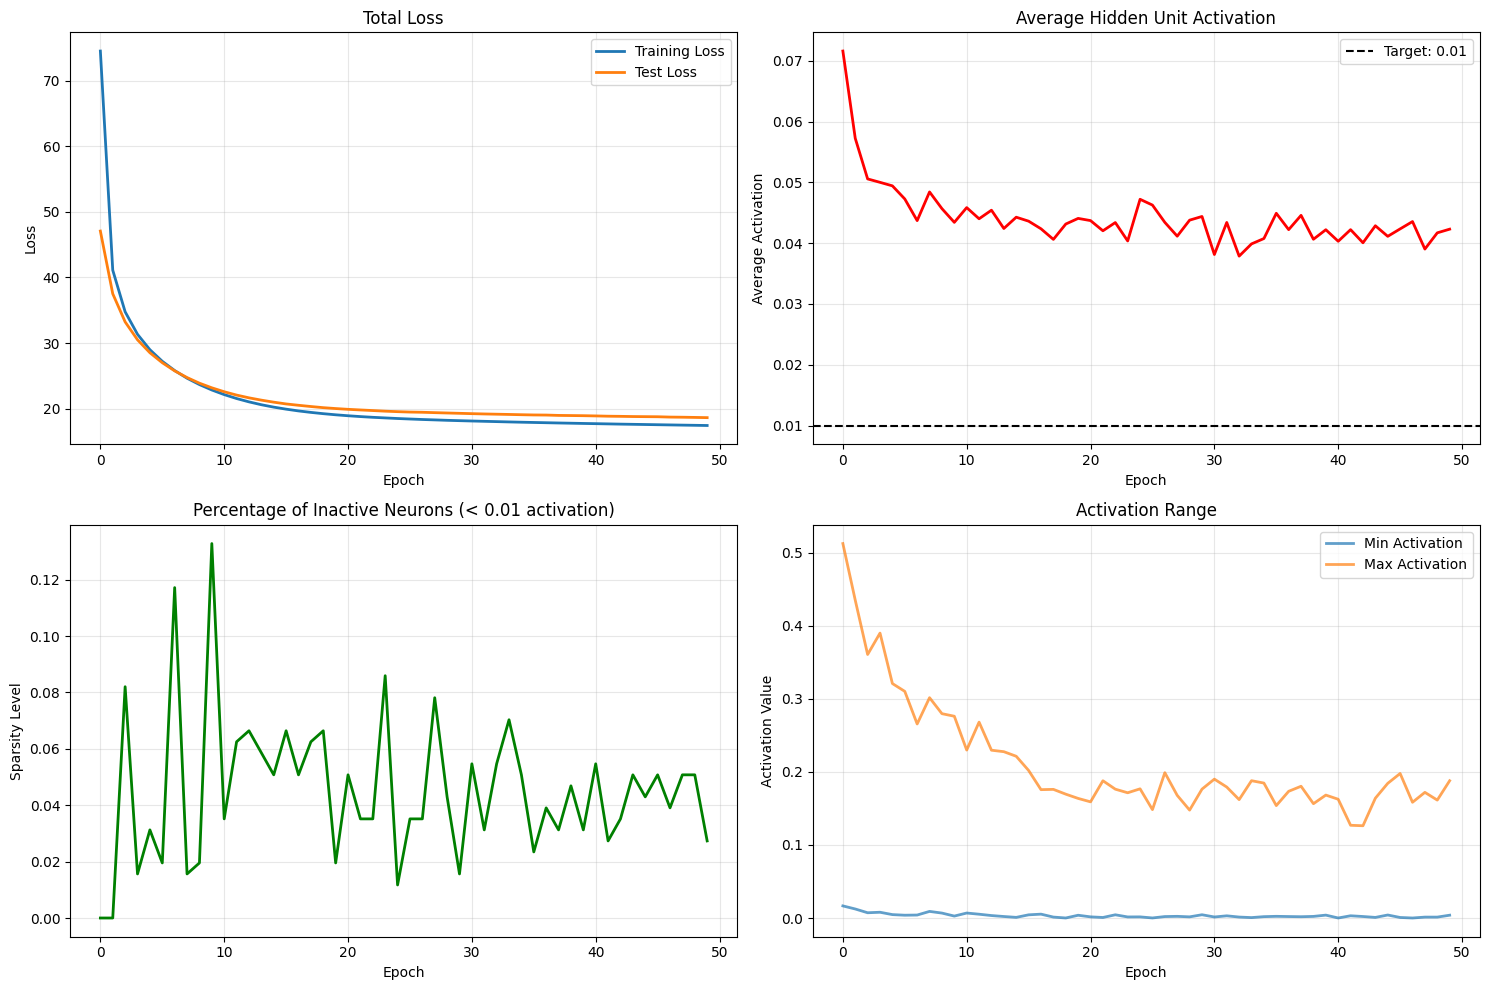

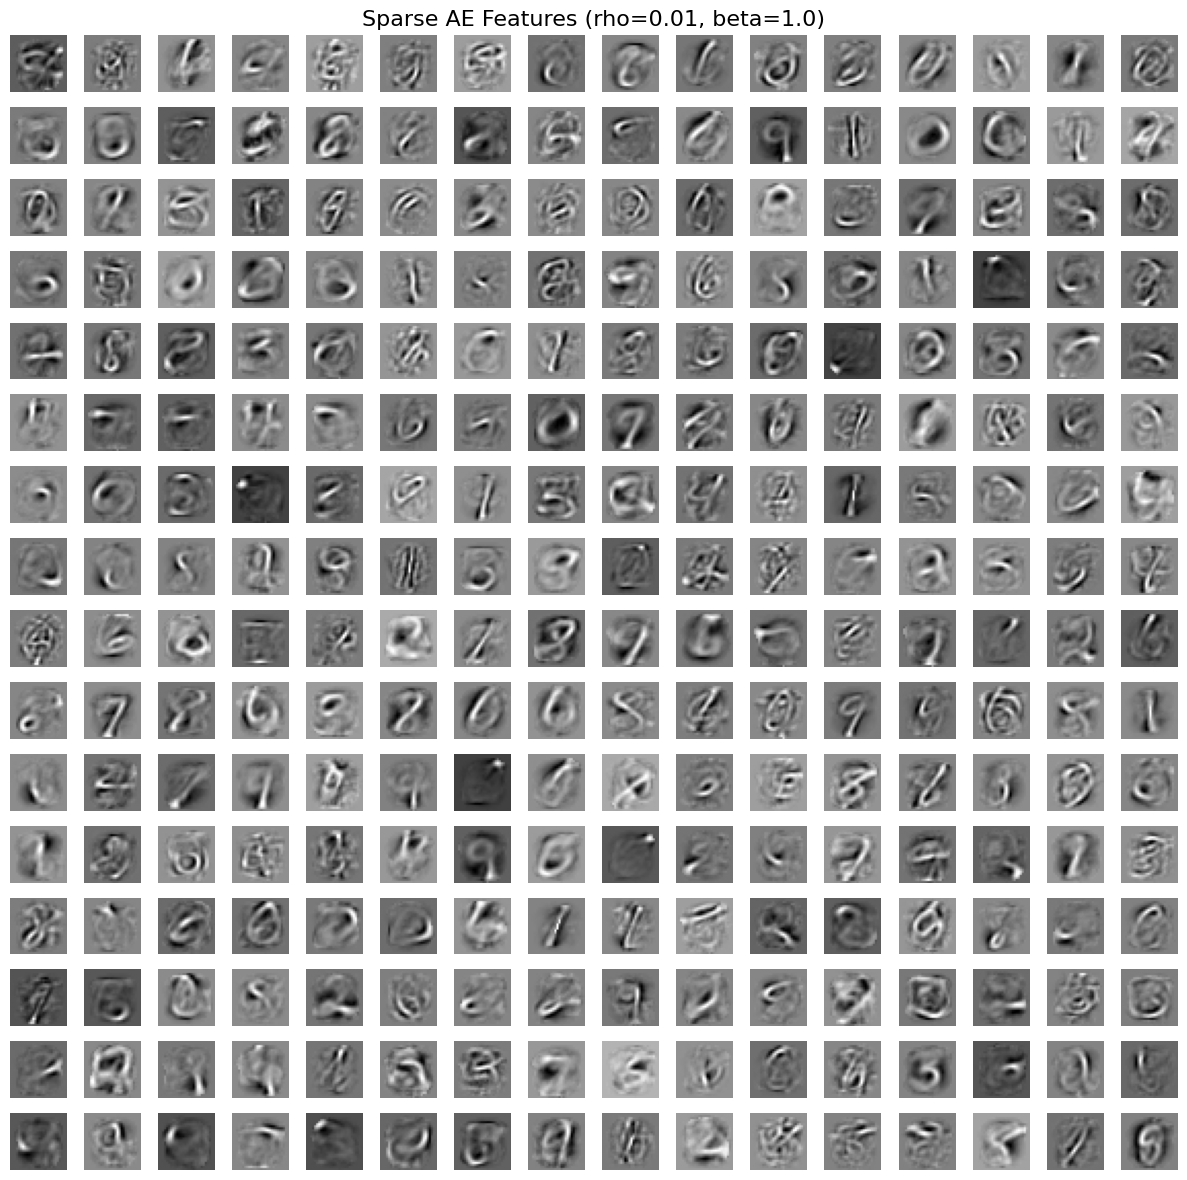


Final Statistics:
  Average Activation: 0.0423 (target: 0.01)
  Sparsity Level: 2.73%
  Final Test Loss: 18.6443

Training with sparsity_param=0.01, beta=3.0
Starting Sparse Autoencoder Training...
Target sparsity: 0.01
Sparsity weight (beta): 3.0
Weight decay (lambda): 0.0001


Epoch 1/50: 100%|██████████| 469/469 [00:10<00:00, 44.15it/s, Total=73.4002, Recon=55.7899, Sparse=17.4303]


Epoch 1:
  Total Loss: 116.8341 | Test Loss: 72.3066
  Recon: 77.8368 | Sparse: 38.8578 | WD: 0.1395
  Avg Activation: 0.0395 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 2/50: 100%|██████████| 469/469 [00:10<00:00, 44.86it/s, Total=53.7825, Recon=40.9995, Sparse=12.5283]


Epoch 2:
  Total Loss: 61.0846 | Test Loss: 55.5792
  Recon: 46.6253 | Sparse: 14.2411 | WD: 0.2181
  Avg Activation: 0.0301 (target: 0.01)
  Sparsity Level: 0.39% neurons < 0.01 activation



Epoch 3/50: 100%|██████████| 469/469 [00:10<00:00, 46.08it/s, Total=46.7081, Recon=35.9913, Sparse=10.3906]


Epoch 3:
  Total Loss: 50.8198 | Test Loss: 49.3975
  Recon: 39.0599 | Sparse: 11.4692 | WD: 0.2907
  Avg Activation: 0.0265 (target: 0.01)
  Sparsity Level: 2.73% neurons < 0.01 activation



Epoch 4/50: 100%|██████████| 469/469 [00:10<00:00, 46.25it/s, Total=44.8394, Recon=35.1742, Sparse=9.2662]


Epoch 4:
  Total Loss: 45.9862 | Test Loss: 45.7872
  Recon: 35.3710 | Sparse: 10.2527 | WD: 0.3625
  Avg Activation: 0.0249 (target: 0.01)
  Sparsity Level: 13.28% neurons < 0.01 activation



Epoch 5/50: 100%|██████████| 469/469 [00:10<00:00, 44.81it/s, Total=42.8694, Recon=33.1516, Sparse=9.2436]


Epoch 5:
  Total Loss: 42.8709 | Test Loss: 43.2491
  Recon: 32.8852 | Sparse: 9.5493 | WD: 0.4365
  Avg Activation: 0.0264 (target: 0.01)
  Sparsity Level: 6.64% neurons < 0.01 activation



Epoch 6/50: 100%|██████████| 469/469 [00:10<00:00, 42.94it/s, Total=39.9456, Recon=30.8453, Sparse=8.5466]


Epoch 6:
  Total Loss: 40.5201 | Test Loss: 41.3036
  Recon: 30.9823 | Sparse: 9.0239 | WD: 0.5139
  Avg Activation: 0.0234 (target: 0.01)
  Sparsity Level: 37.89% neurons < 0.01 activation



Epoch 7/50: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s, Total=37.5915, Recon=27.8321, Sparse=9.1225]


Epoch 7:
  Total Loss: 38.5748 | Test Loss: 39.6195
  Recon: 29.3419 | Sparse: 8.6378 | WD: 0.5951
  Avg Activation: 0.0271 (target: 0.01)
  Sparsity Level: 4.30% neurons < 0.01 activation



Epoch 8/50: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s, Total=36.3465, Recon=27.4982, Sparse=8.1252]


Epoch 8:
  Total Loss: 36.8345 | Test Loss: 38.0911
  Recon: 27.7963 | Sparse: 8.3585 | WD: 0.6798
  Avg Activation: 0.0248 (target: 0.01)
  Sparsity Level: 22.66% neurons < 0.01 activation



Epoch 9/50: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s, Total=34.8477, Recon=26.0048, Sparse=8.0309]


Epoch 9:
  Total Loss: 35.2177 | Test Loss: 36.7335
  Recon: 26.3283 | Sparse: 8.1219 | WD: 0.7675
  Avg Activation: 0.0241 (target: 0.01)
  Sparsity Level: 35.16% neurons < 0.01 activation



Epoch 10/50: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s, Total=34.5051, Recon=26.8436, Sparse=6.7613]


Epoch 10:
  Total Loss: 33.7577 | Test Loss: 35.4995
  Recon: 24.9810 | Sparse: 7.9204 | WD: 0.8564
  Avg Activation: 0.0224 (target: 0.01)
  Sparsity Level: 34.38% neurons < 0.01 activation



Epoch 11/50: 100%|██████████| 469/469 [00:09<00:00, 46.99it/s, Total=33.3741, Recon=24.9251, Sparse=7.4641]


Epoch 11:
  Total Loss: 32.4554 | Test Loss: 34.4380
  Recon: 23.7593 | Sparse: 7.7529 | WD: 0.9433
  Avg Activation: 0.0240 (target: 0.01)
  Sparsity Level: 23.44% neurons < 0.01 activation



Epoch 12/50: 100%|██████████| 469/469 [00:10<00:00, 45.90it/s, Total=31.3857, Recon=22.8567, Sparse=7.4664]


Epoch 12:
  Total Loss: 31.3014 | Test Loss: 33.5057
  Recon: 22.6749 | Sparse: 7.6021 | WD: 1.0243
  Avg Activation: 0.0244 (target: 0.01)
  Sparsity Level: 29.69% neurons < 0.01 activation



Epoch 13/50: 100%|██████████| 469/469 [00:10<00:00, 45.02it/s, Total=30.9952, Recon=22.4646, Sparse=7.3999]


Epoch 13:
  Total Loss: 30.2908 | Test Loss: 32.6629
  Recon: 21.7488 | Sparse: 7.4445 | WD: 1.0975
  Avg Activation: 0.0241 (target: 0.01)
  Sparsity Level: 26.17% neurons < 0.01 activation



Epoch 14/50: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s, Total=30.7736, Recon=21.9622, Sparse=7.6213]


Epoch 14:
  Total Loss: 29.3900 | Test Loss: 32.0401
  Recon: 20.9136 | Sparse: 7.3154 | WD: 1.1609
  Avg Activation: 0.0250 (target: 0.01)
  Sparsity Level: 25.39% neurons < 0.01 activation



Epoch 15/50: 100%|██████████| 469/469 [00:11<00:00, 41.47it/s, Total=28.9857, Recon=21.2382, Sparse=6.5085]


Epoch 15:
  Total Loss: 28.6155 | Test Loss: 31.4784
  Recon: 20.2115 | Sparse: 7.1885 | WD: 1.2155
  Avg Activation: 0.0232 (target: 0.01)
  Sparsity Level: 20.31% neurons < 0.01 activation



Epoch 16/50: 100%|██████████| 469/469 [00:10<00:00, 44.07it/s, Total=26.9024, Recon=18.2756, Sparse=7.3476]


Epoch 16:
  Total Loss: 27.9393 | Test Loss: 30.9375
  Recon: 19.6022 | Sparse: 7.0775 | WD: 1.2597
  Avg Activation: 0.0260 (target: 0.01)
  Sparsity Level: 12.89% neurons < 0.01 activation



Epoch 17/50: 100%|██████████| 469/469 [00:10<00:00, 43.18it/s, Total=28.7598, Recon=20.2642, Sparse=7.1817]


Epoch 17:
  Total Loss: 27.3673 | Test Loss: 30.5553
  Recon: 19.0529 | Sparse: 7.0173 | WD: 1.2971
  Avg Activation: 0.0250 (target: 0.01)
  Sparsity Level: 16.41% neurons < 0.01 activation



Epoch 18/50: 100%|██████████| 469/469 [00:10<00:00, 46.19it/s, Total=26.3148, Recon=18.0958, Sparse=6.8741]


Epoch 18:
  Total Loss: 26.8533 | Test Loss: 30.2231
  Recon: 18.6243 | Sparse: 6.8993 | WD: 1.3298
  Avg Activation: 0.0251 (target: 0.01)
  Sparsity Level: 16.80% neurons < 0.01 activation



Epoch 19/50: 100%|██████████| 469/469 [00:10<00:00, 46.82it/s, Total=26.1640, Recon=16.5039, Sparse=8.2852]


Epoch 19:
  Total Loss: 26.4165 | Test Loss: 29.9745
  Recon: 18.2357 | Sparse: 6.8208 | WD: 1.3599
  Avg Activation: 0.0277 (target: 0.01)
  Sparsity Level: 13.67% neurons < 0.01 activation



Epoch 20/50: 100%|██████████| 469/469 [00:10<00:00, 44.83it/s, Total=24.7929, Recon=16.1902, Sparse=7.1977]


Epoch 20:
  Total Loss: 26.0598 | Test Loss: 29.7293
  Recon: 17.9109 | Sparse: 6.7587 | WD: 1.3902
  Avg Activation: 0.0257 (target: 0.01)
  Sparsity Level: 14.84% neurons < 0.01 activation



Epoch 21/50: 100%|██████████| 469/469 [00:10<00:00, 42.89it/s, Total=26.6138, Recon=17.3919, Sparse=7.7876]


Epoch 21:
  Total Loss: 25.7787 | Test Loss: 29.5514
  Recon: 17.6192 | Sparse: 6.7400 | WD: 1.4195
  Avg Activation: 0.0273 (target: 0.01)
  Sparsity Level: 9.77% neurons < 0.01 activation



Epoch 22/50: 100%|██████████| 469/469 [00:10<00:00, 44.51it/s, Total=25.4510, Recon=16.5539, Sparse=7.4320]


Epoch 22:
  Total Loss: 25.5196 | Test Loss: 29.4183
  Recon: 17.3894 | Sparse: 6.6804 | WD: 1.4499
  Avg Activation: 0.0266 (target: 0.01)
  Sparsity Level: 15.62% neurons < 0.01 activation



Epoch 23/50: 100%|██████████| 469/469 [00:10<00:00, 43.41it/s, Total=26.0616, Recon=18.0985, Sparse=6.4677]


Epoch 23:
  Total Loss: 25.2914 | Test Loss: 29.3127
  Recon: 17.1718 | Sparse: 6.6390 | WD: 1.4806
  Avg Activation: 0.0241 (target: 0.01)
  Sparsity Level: 19.92% neurons < 0.01 activation



Epoch 24/50: 100%|██████████| 469/469 [00:10<00:00, 43.78it/s, Total=26.1862, Recon=16.4513, Sparse=8.2095]


Epoch 24:
  Total Loss: 25.1306 | Test Loss: 29.2845
  Recon: 16.9869 | Sparse: 6.6330 | WD: 1.5107
  Avg Activation: 0.0270 (target: 0.01)
  Sparsity Level: 14.45% neurons < 0.01 activation



Epoch 25/50: 100%|██████████| 469/469 [00:10<00:00, 45.58it/s, Total=25.5898, Recon=15.9109, Sparse=8.1245]


Epoch 25:
  Total Loss: 24.9720 | Test Loss: 29.1555
  Recon: 16.8215 | Sparse: 6.6107 | WD: 1.5398
  Avg Activation: 0.0280 (target: 0.01)
  Sparsity Level: 13.28% neurons < 0.01 activation



Epoch 26/50: 100%|██████████| 469/469 [00:10<00:00, 46.89it/s, Total=25.5842, Recon=16.1070, Sparse=7.8950]


Epoch 26:
  Total Loss: 24.8205 | Test Loss: 29.0784
  Recon: 16.7033 | Sparse: 6.5484 | WD: 1.5688
  Avg Activation: 0.0284 (target: 0.01)
  Sparsity Level: 9.38% neurons < 0.01 activation



Epoch 27/50: 100%|██████████| 469/469 [00:10<00:00, 45.64it/s, Total=25.3503, Recon=15.8573, Sparse=7.8842]


Epoch 27:
  Total Loss: 24.7060 | Test Loss: 28.9817
  Recon: 16.5751 | Sparse: 6.5346 | WD: 1.5963
  Avg Activation: 0.0275 (target: 0.01)
  Sparsity Level: 12.89% neurons < 0.01 activation



Epoch 28/50: 100%|██████████| 469/469 [00:10<00:00, 44.71it/s, Total=24.1443, Recon=14.9602, Sparse=7.5505]


Epoch 28:
  Total Loss: 24.5895 | Test Loss: 28.9873
  Recon: 16.4575 | Sparse: 6.5101 | WD: 1.6218
  Avg Activation: 0.0255 (target: 0.01)
  Sparsity Level: 14.84% neurons < 0.01 activation



Epoch 29/50: 100%|██████████| 469/469 [00:10<00:00, 45.31it/s, Total=25.2987, Recon=16.7117, Sparse=6.9298]


Epoch 29:
  Total Loss: 24.5057 | Test Loss: 28.9852
  Recon: 16.3506 | Sparse: 6.5094 | WD: 1.6457
  Avg Activation: 0.0252 (target: 0.01)
  Sparsity Level: 11.33% neurons < 0.01 activation



Epoch 30/50: 100%|██████████| 469/469 [00:10<00:00, 43.68it/s, Total=24.5750, Recon=15.8454, Sparse=7.0518]


Epoch 30:
  Total Loss: 24.4266 | Test Loss: 28.8823
  Recon: 16.2752 | Sparse: 6.4837 | WD: 1.6677
  Avg Activation: 0.0261 (target: 0.01)
  Sparsity Level: 10.16% neurons < 0.01 activation



Epoch 31/50: 100%|██████████| 469/469 [00:10<00:00, 43.91it/s, Total=23.9980, Recon=15.5813, Sparse=6.7194]


Epoch 31:
  Total Loss: 24.3548 | Test Loss: 28.8468
  Recon: 16.1950 | Sparse: 6.4715 | WD: 1.6882
  Avg Activation: 0.0243 (target: 0.01)
  Sparsity Level: 16.41% neurons < 0.01 activation



Epoch 32/50: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s, Total=25.9326, Recon=16.8147, Sparse=7.4021]


Epoch 32:
  Total Loss: 24.2666 | Test Loss: 28.8060
  Recon: 16.1224 | Sparse: 6.4372 | WD: 1.7070
  Avg Activation: 0.0263 (target: 0.01)
  Sparsity Level: 12.89% neurons < 0.01 activation



Epoch 33/50: 100%|██████████| 469/469 [00:09<00:00, 47.71it/s, Total=24.1748, Recon=15.4294, Sparse=7.0117]


Epoch 33:
  Total Loss: 24.2249 | Test Loss: 28.8559
  Recon: 16.0575 | Sparse: 6.4426 | WD: 1.7248
  Avg Activation: 0.0241 (target: 0.01)
  Sparsity Level: 19.14% neurons < 0.01 activation



Epoch 34/50: 100%|██████████| 469/469 [00:10<00:00, 45.44it/s, Total=24.9516, Recon=15.6656, Sparse=7.5376]


Epoch 34:
  Total Loss: 24.1453 | Test Loss: 28.8000
  Recon: 16.0053 | Sparse: 6.3988 | WD: 1.7411
  Avg Activation: 0.0266 (target: 0.01)
  Sparsity Level: 16.02% neurons < 0.01 activation



Epoch 35/50: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s, Total=25.3922, Recon=15.8969, Sparse=7.7329]


Epoch 35:
  Total Loss: 24.1171 | Test Loss: 28.7797
  Recon: 15.9399 | Sparse: 6.4215 | WD: 1.7557
  Avg Activation: 0.0274 (target: 0.01)
  Sparsity Level: 12.50% neurons < 0.01 activation



Epoch 36/50: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s, Total=23.2928, Recon=14.5421, Sparse=6.9748]


Epoch 36:
  Total Loss: 24.0482 | Test Loss: 28.7102
  Recon: 15.9063 | Sparse: 6.3723 | WD: 1.7695
  Avg Activation: 0.0262 (target: 0.01)
  Sparsity Level: 10.16% neurons < 0.01 activation



Epoch 37/50: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s, Total=23.7303, Recon=15.2675, Sparse=6.6757]


Epoch 37:
  Total Loss: 24.0174 | Test Loss: 28.7007
  Recon: 15.8548 | Sparse: 6.3805 | WD: 1.7821
  Avg Activation: 0.0259 (target: 0.01)
  Sparsity Level: 11.33% neurons < 0.01 activation



Epoch 38/50: 100%|██████████| 469/469 [00:10<00:00, 43.91it/s, Total=27.0625, Recon=17.6152, Sparse=7.6487]


Epoch 38:
  Total Loss: 23.9824 | Test Loss: 28.7522
  Recon: 15.8040 | Sparse: 6.3856 | WD: 1.7929
  Avg Activation: 0.0251 (target: 0.01)
  Sparsity Level: 17.19% neurons < 0.01 activation



Epoch 39/50: 100%|██████████| 469/469 [00:10<00:00, 43.20it/s, Total=24.8901, Recon=15.3785, Sparse=7.7031]


Epoch 39:
  Total Loss: 23.9203 | Test Loss: 28.7022
  Recon: 15.7844 | Sparse: 6.3325 | WD: 1.8034
  Avg Activation: 0.0264 (target: 0.01)
  Sparsity Level: 15.62% neurons < 0.01 activation



Epoch 40/50: 100%|██████████| 469/469 [00:10<00:00, 45.05it/s, Total=24.7705, Recon=16.0710, Sparse=6.8822]


Epoch 40:
  Total Loss: 23.8964 | Test Loss: 28.6762
  Recon: 15.7395 | Sparse: 6.3431 | WD: 1.8138
  Avg Activation: 0.0250 (target: 0.01)
  Sparsity Level: 14.06% neurons < 0.01 activation



Epoch 41/50: 100%|██████████| 469/469 [00:10<00:00, 46.33it/s, Total=24.2745, Recon=15.1361, Sparse=7.3130]


Epoch 41:
  Total Loss: 23.8768 | Test Loss: 28.6560
  Recon: 15.6934 | Sparse: 6.3617 | WD: 1.8217
  Avg Activation: 0.0258 (target: 0.01)
  Sparsity Level: 13.28% neurons < 0.01 activation



Epoch 42/50: 100%|██████████| 469/469 [00:10<00:00, 44.57it/s, Total=24.4150, Recon=16.1039, Sparse=6.4779]


Epoch 42:
  Total Loss: 23.8447 | Test Loss: 28.6142
  Recon: 15.6587 | Sparse: 6.3564 | WD: 1.8297
  Avg Activation: 0.0252 (target: 0.01)
  Sparsity Level: 13.67% neurons < 0.01 activation



Epoch 43/50: 100%|██████████| 469/469 [00:10<00:00, 44.46it/s, Total=24.5053, Recon=15.8113, Sparse=6.8530]


Epoch 43:
  Total Loss: 23.7967 | Test Loss: 28.6339
  Recon: 15.6323 | Sparse: 6.3270 | WD: 1.8374
  Avg Activation: 0.0253 (target: 0.01)
  Sparsity Level: 12.89% neurons < 0.01 activation



Epoch 44/50: 100%|██████████| 469/469 [00:10<00:00, 45.08it/s, Total=25.5962, Recon=16.7259, Sparse=7.0230]


Epoch 44:
  Total Loss: 23.7817 | Test Loss: 28.5891
  Recon: 15.6033 | Sparse: 6.3339 | WD: 1.8444
  Avg Activation: 0.0260 (target: 0.01)
  Sparsity Level: 12.50% neurons < 0.01 activation



Epoch 45/50: 100%|██████████| 469/469 [00:10<00:00, 45.28it/s, Total=24.3418, Recon=16.0622, Sparse=6.4258]


Epoch 45:
  Total Loss: 23.7272 | Test Loss: 28.5807
  Recon: 15.5785 | Sparse: 6.2975 | WD: 1.8512
  Avg Activation: 0.0237 (target: 0.01)
  Sparsity Level: 18.36% neurons < 0.01 activation



Epoch 46/50: 100%|██████████| 469/469 [00:10<00:00, 46.32it/s, Total=23.6572, Recon=14.7289, Sparse=7.0690]


Epoch 46:
  Total Loss: 23.7186 | Test Loss: 28.5483
  Recon: 15.5462 | Sparse: 6.3156 | WD: 1.8568
  Avg Activation: 0.0253 (target: 0.01)
  Sparsity Level: 14.84% neurons < 0.01 activation



Epoch 47/50: 100%|██████████| 469/469 [00:10<00:00, 46.80it/s, Total=26.7716, Recon=17.3197, Sparse=7.5872]


Epoch 47:
  Total Loss: 23.6757 | Test Loss: 28.5320
  Recon: 15.5270 | Sparse: 6.2865 | WD: 1.8621
  Avg Activation: 0.0264 (target: 0.01)
  Sparsity Level: 15.62% neurons < 0.01 activation



Epoch 48/50: 100%|██████████| 469/469 [00:10<00:00, 44.76it/s, Total=24.0889, Recon=15.5010, Sparse=6.7193]


Epoch 48:
  Total Loss: 23.6647 | Test Loss: 28.4609
  Recon: 15.4982 | Sparse: 6.2992 | WD: 1.8673
  Avg Activation: 0.0258 (target: 0.01)
  Sparsity Level: 11.33% neurons < 0.01 activation



Epoch 49/50: 100%|██████████| 469/469 [00:10<00:00, 44.55it/s, Total=22.6844, Recon=14.2586, Sparse=6.5516]


Epoch 49:
  Total Loss: 23.6279 | Test Loss: 28.5389
  Recon: 15.4677 | Sparse: 6.2888 | WD: 1.8714
  Avg Activation: 0.0248 (target: 0.01)
  Sparsity Level: 14.45% neurons < 0.01 activation



Epoch 50/50: 100%|██████████| 469/469 [00:11<00:00, 42.52it/s, Total=23.4351, Recon=14.9720, Sparse=6.5844]


Epoch 50:
  Total Loss: 23.6073 | Test Loss: 28.4889
  Recon: 15.4606 | Sparse: 6.2703 | WD: 1.8764
  Avg Activation: 0.0245 (target: 0.01)
  Sparsity Level: 17.58% neurons < 0.01 activation



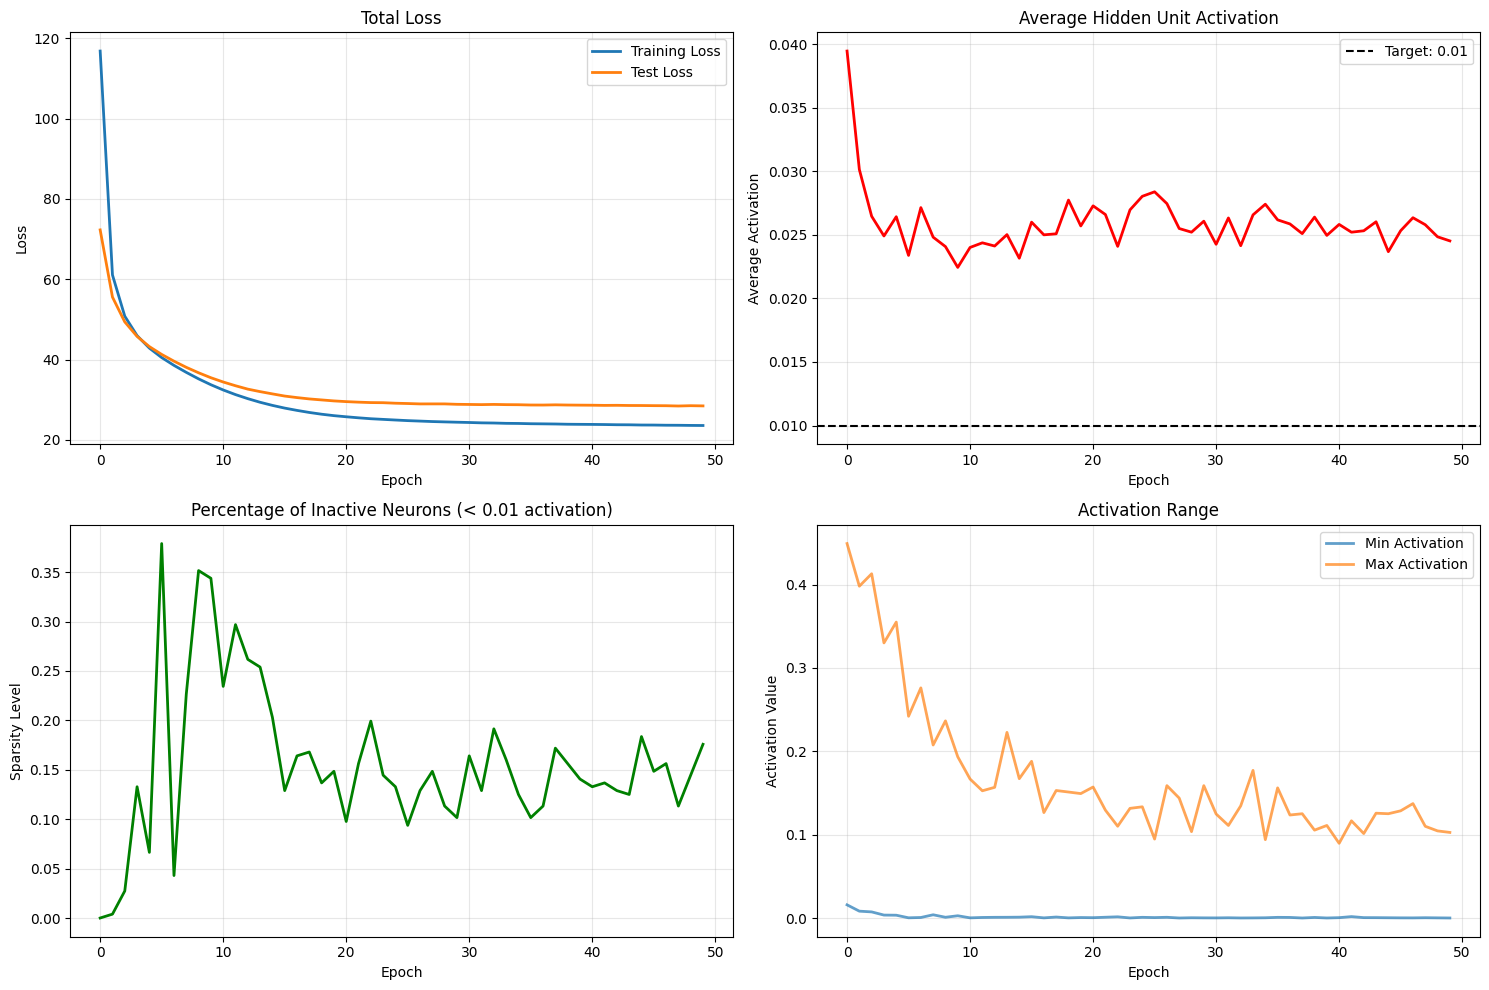

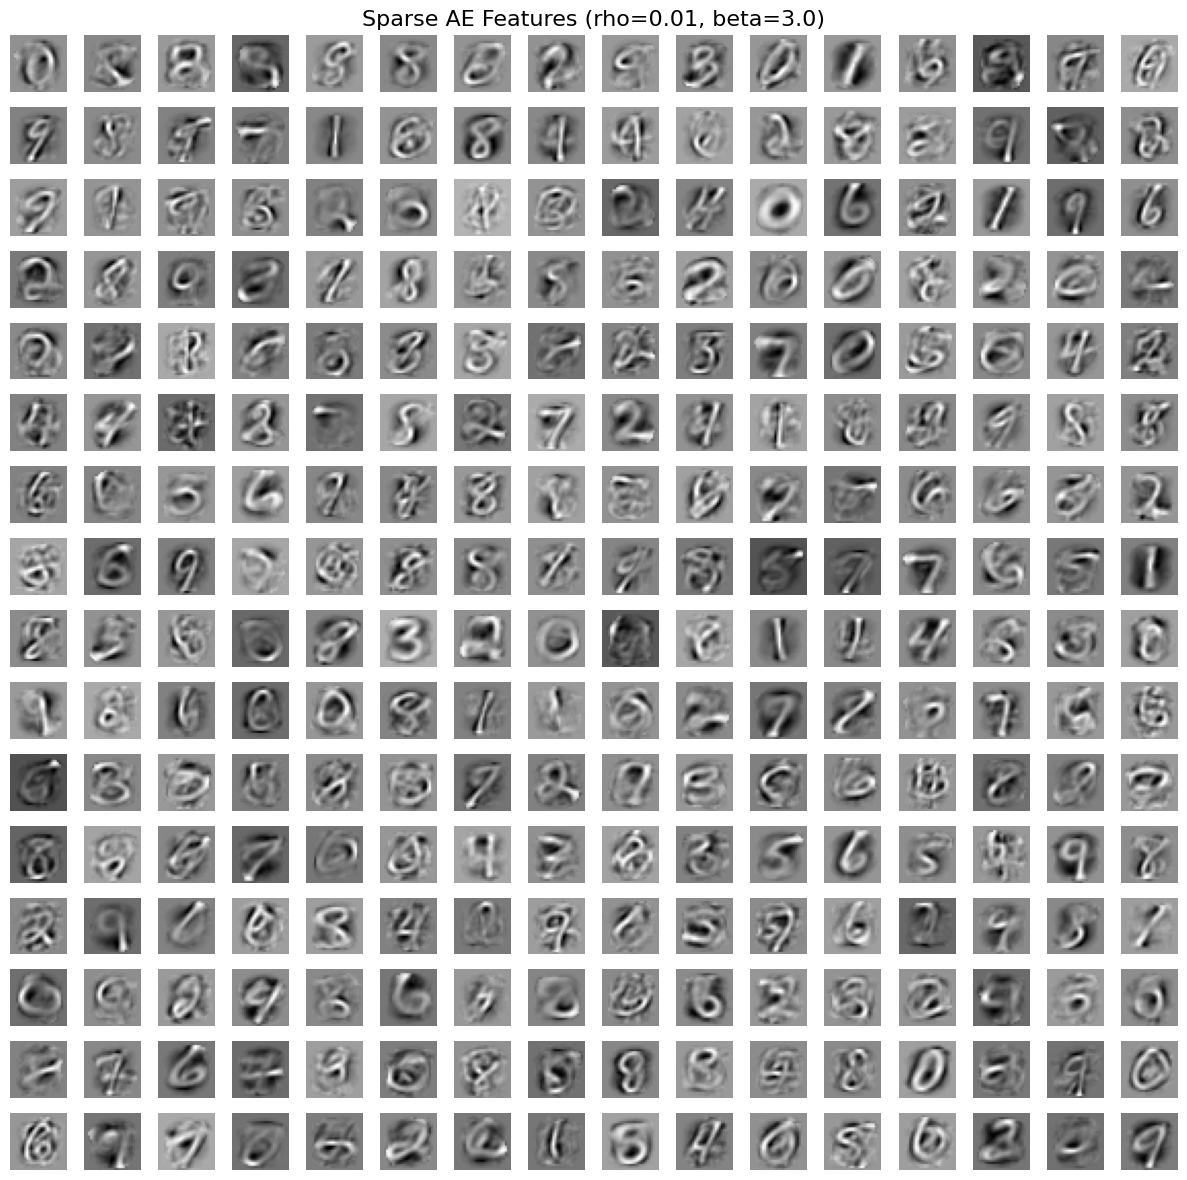


Final Statistics:
  Average Activation: 0.0245 (target: 0.01)
  Sparsity Level: 17.58%
  Final Test Loss: 28.4889

Training with sparsity_param=0.01, beta=10.0
Starting Sparse Autoencoder Training...
Target sparsity: 0.01
Sparsity weight (beta): 10.0
Weight decay (lambda): 0.0001


Epoch 1/50: 100%|██████████| 469/469 [00:10<00:00, 44.28it/s, Total=101.9003, Recon=91.1299, Sparse=10.6099]


Epoch 1:
  Total Loss: 186.4733 | Test Loss: 105.7196
  Recon: 113.6201 | Sparse: 72.7217 | WD: 0.1315
  Avg Activation: 0.0195 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 2/50: 100%|██████████| 469/469 [00:10<00:00, 42.66it/s, Total=76.1024, Recon=66.6622, Sparse=9.2220]


Epoch 2:
  Total Loss: 85.6249 | Test Loss: 79.8539
  Recon: 74.9417 | Sparse: 10.4917 | WD: 0.1914
  Avg Activation: 0.0152 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 3/50: 100%|██████████| 469/469 [00:10<00:00, 44.73it/s, Total=68.3199, Recon=60.2110, Sparse=7.8421]


Epoch 3:
  Total Loss: 71.8260 | Test Loss: 71.8008
  Recon: 63.0164 | Sparse: 8.5671 | WD: 0.2425
  Avg Activation: 0.0149 (target: 0.01)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 4/50: 100%|██████████| 469/469 [00:10<00:00, 45.10it/s, Total=63.0511, Recon=54.7022, Sparse=8.0268]


Epoch 4:
  Total Loss: 65.4130 | Test Loss: 66.7747
  Recon: 58.1367 | Sparse: 6.9827 | WD: 0.2937
  Avg Activation: 0.0167 (target: 0.01)
  Sparsity Level: 0.78% neurons < 0.01 activation



Epoch 5/50: 100%|██████████| 469/469 [00:10<00:00, 44.90it/s, Total=58.8093, Recon=54.1810, Sparse=4.2431]


Epoch 5:
  Total Loss: 60.9006 | Test Loss: 63.1122
  Recon: 54.7089 | Sparse: 5.8382 | WD: 0.3535
  Avg Activation: 0.0121 (target: 0.01)
  Sparsity Level: 48.44% neurons < 0.01 activation



Epoch 6/50: 100%|██████████| 469/469 [00:09<00:00, 47.14it/s, Total=55.8002, Recon=50.9562, Sparse=4.3956]


Epoch 6:
  Total Loss: 57.4921 | Test Loss: 60.4633
  Recon: 51.9859 | Sparse: 5.0890 | WD: 0.4172
  Avg Activation: 0.0133 (target: 0.01)
  Sparsity Level: 18.36% neurons < 0.01 activation



Epoch 7/50: 100%|██████████| 469/469 [00:10<00:00, 45.80it/s, Total=52.9104, Recon=47.5854, Sparse=4.8191]


Epoch 7:
  Total Loss: 54.7864 | Test Loss: 58.3268
  Recon: 49.6504 | Sparse: 4.6585 | WD: 0.4775
  Avg Activation: 0.0129 (target: 0.01)
  Sparsity Level: 48.44% neurons < 0.01 activation



Epoch 8/50: 100%|██████████| 469/469 [00:10<00:00, 43.86it/s, Total=51.7503, Recon=45.0220, Sparse=6.1714]


Epoch 8:
  Total Loss: 52.5188 | Test Loss: 56.4620
  Recon: 47.2882 | Sparse: 4.6985 | WD: 0.5320
  Avg Activation: 0.0151 (target: 0.01)
  Sparsity Level: 7.81% neurons < 0.01 activation



Epoch 9/50: 100%|██████████| 469/469 [00:10<00:00, 43.90it/s, Total=49.7662, Recon=43.5679, Sparse=5.5966]


Epoch 9:
  Total Loss: 50.4256 | Test Loss: 55.0854
  Recon: 44.8883 | Sparse: 4.9575 | WD: 0.5798
  Avg Activation: 0.0145 (target: 0.01)
  Sparsity Level: 18.75% neurons < 0.01 activation



Epoch 10/50: 100%|██████████| 469/469 [00:10<00:00, 44.96it/s, Total=46.8849, Recon=40.8277, Sparse=5.4183]


Epoch 10:
  Total Loss: 48.5811 | Test Loss: 53.9210
  Recon: 42.6189 | Sparse: 5.3415 | WD: 0.6207
  Avg Activation: 0.0154 (target: 0.01)
  Sparsity Level: 8.20% neurons < 0.01 activation



Epoch 11/50: 100%|██████████| 469/469 [00:10<00:00, 43.95it/s, Total=46.7754, Recon=40.1412, Sparse=5.9650]


Epoch 11:
  Total Loss: 46.9824 | Test Loss: 52.9244
  Recon: 40.5923 | Sparse: 5.7353 | WD: 0.6548
  Avg Activation: 0.0129 (target: 0.01)
  Sparsity Level: 50.00% neurons < 0.01 activation



Epoch 12/50: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s, Total=44.4618, Recon=36.0225, Sparse=7.7446]


Epoch 12:
  Total Loss: 45.5362 | Test Loss: 52.2097
  Recon: 38.7009 | Sparse: 6.1528 | WD: 0.6825
  Avg Activation: 0.0171 (target: 0.01)
  Sparsity Level: 10.94% neurons < 0.01 activation



Epoch 13/50: 100%|██████████| 469/469 [00:10<00:00, 46.08it/s, Total=44.8820, Recon=35.2155, Sparse=8.9503]


Epoch 13:
  Total Loss: 44.2248 | Test Loss: 51.4204
  Recon: 37.0750 | Sparse: 6.4442 | WD: 0.7057
  Avg Activation: 0.0140 (target: 0.01)
  Sparsity Level: 50.78% neurons < 0.01 activation



Epoch 14/50: 100%|██████████| 469/469 [00:11<00:00, 42.53it/s, Total=41.0680, Recon=34.2143, Sparse=6.1177]


Epoch 14:
  Total Loss: 43.0655 | Test Loss: 51.1091
  Recon: 35.5927 | Sparse: 6.7468 | WD: 0.7259
  Avg Activation: 0.0145 (target: 0.01)
  Sparsity Level: 28.91% neurons < 0.01 activation



Epoch 15/50: 100%|██████████| 469/469 [00:10<00:00, 45.73it/s, Total=41.9823, Recon=34.1918, Sparse=7.0353]


Epoch 15:
  Total Loss: 42.0264 | Test Loss: 50.4254
  Recon: 34.3817 | Sparse: 6.8991 | WD: 0.7457
  Avg Activation: 0.0142 (target: 0.01)
  Sparsity Level: 36.72% neurons < 0.01 activation



Epoch 16/50: 100%|██████████| 469/469 [00:10<00:00, 43.69it/s, Total=40.8894, Recon=31.0403, Sparse=9.0727]


Epoch 16:
  Total Loss: 41.0843 | Test Loss: 50.0261
  Recon: 33.2420 | Sparse: 7.0765 | WD: 0.7658
  Avg Activation: 0.0171 (target: 0.01)
  Sparsity Level: 19.14% neurons < 0.01 activation



Epoch 17/50: 100%|██████████| 469/469 [00:10<00:00, 44.44it/s, Total=40.7033, Recon=32.4797, Sparse=7.4231]


Epoch 17:
  Total Loss: 40.3016 | Test Loss: 49.5847
  Recon: 32.2564 | Sparse: 7.2568 | WD: 0.7884
  Avg Activation: 0.0142 (target: 0.01)
  Sparsity Level: 43.36% neurons < 0.01 activation



Epoch 18/50: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s, Total=41.3575, Recon=31.1576, Sparse=9.3707]


Epoch 18:
  Total Loss: 39.6090 | Test Loss: 49.4132
  Recon: 31.3788 | Sparse: 7.4155 | WD: 0.8147
  Avg Activation: 0.0158 (target: 0.01)
  Sparsity Level: 32.42% neurons < 0.01 activation



Epoch 19/50: 100%|██████████| 469/469 [00:10<00:00, 45.27it/s, Total=40.0470, Recon=29.2479, Sparse=9.9361]


Epoch 19:
  Total Loss: 38.9677 | Test Loss: 49.3616
  Recon: 30.5798 | Sparse: 7.5424 | WD: 0.8454
  Avg Activation: 0.0174 (target: 0.01)
  Sparsity Level: 16.80% neurons < 0.01 activation



Epoch 20/50: 100%|██████████| 469/469 [00:10<00:00, 44.75it/s, Total=39.3586, Recon=28.1605, Sparse=10.2979]


Epoch 20:
  Total Loss: 38.4911 | Test Loss: 49.0604
  Recon: 29.9004 | Sparse: 7.7096 | WD: 0.8812
  Avg Activation: 0.0179 (target: 0.01)
  Sparsity Level: 16.80% neurons < 0.01 activation



Epoch 21/50: 100%|██████████| 469/469 [00:10<00:00, 46.50it/s, Total=40.9990, Recon=28.6431, Sparse=11.4147]


Epoch 21:
  Total Loss: 37.9866 | Test Loss: 48.9732
  Recon: 29.2797 | Sparse: 7.7861 | WD: 0.9208
  Avg Activation: 0.0149 (target: 0.01)
  Sparsity Level: 39.06% neurons < 0.01 activation



Epoch 22/50: 100%|██████████| 469/469 [00:10<00:00, 45.65it/s, Total=40.2975, Recon=26.5447, Sparse=12.7672]


Epoch 22:
  Total Loss: 37.6078 | Test Loss: 49.1249
  Recon: 28.6987 | Sparse: 7.9462 | WD: 0.9630
  Avg Activation: 0.0167 (target: 0.01)
  Sparsity Level: 25.39% neurons < 0.01 activation



Epoch 23/50: 100%|██████████| 469/469 [00:10<00:00, 44.42it/s, Total=37.9549, Recon=27.2670, Sparse=9.6580]


Epoch 23:
  Total Loss: 37.2706 | Test Loss: 48.8629
  Recon: 28.2031 | Sparse: 8.0595 | WD: 1.0081
  Avg Activation: 0.0170 (target: 0.01)
  Sparsity Level: 25.00% neurons < 0.01 activation



Epoch 24/50: 100%|██████████| 469/469 [00:10<00:00, 43.32it/s, Total=38.0575, Recon=27.7771, Sparse=9.2032]


Epoch 24:
  Total Loss: 36.9732 | Test Loss: 48.9103
  Recon: 27.7539 | Sparse: 8.1653 | WD: 1.0541
  Avg Activation: 0.0151 (target: 0.01)
  Sparsity Level: 39.45% neurons < 0.01 activation



Epoch 25/50: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s, Total=39.0172, Recon=27.6539, Sparse=10.2382]


Epoch 25:
  Total Loss: 36.6433 | Test Loss: 48.9464
  Recon: 27.3442 | Sparse: 8.1981 | WD: 1.1010
  Avg Activation: 0.0143 (target: 0.01)
  Sparsity Level: 46.48% neurons < 0.01 activation



Epoch 26/50: 100%|██████████| 469/469 [00:10<00:00, 44.82it/s, Total=37.4462, Recon=25.7524, Sparse=10.5224]


Epoch 26:
  Total Loss: 36.4470 | Test Loss: 48.7826
  Recon: 26.9497 | Sparse: 8.3491 | WD: 1.1482
  Avg Activation: 0.0161 (target: 0.01)
  Sparsity Level: 30.08% neurons < 0.01 activation



Epoch 27/50: 100%|██████████| 469/469 [00:09<00:00, 47.31it/s, Total=38.7321, Recon=27.9123, Sparse=9.6032]


Epoch 27:
  Total Loss: 36.2377 | Test Loss: 48.7930
  Recon: 26.5926 | Sparse: 8.4506 | WD: 1.1944
  Avg Activation: 0.0149 (target: 0.01)
  Sparsity Level: 33.59% neurons < 0.01 activation



Epoch 28/50: 100%|██████████| 469/469 [00:10<00:00, 45.00it/s, Total=40.7198, Recon=28.7017, Sparse=10.7582]


Epoch 28:
  Total Loss: 36.0240 | Test Loss: 48.8592
  Recon: 26.2899 | Sparse: 8.4958 | WD: 1.2383
  Avg Activation: 0.0151 (target: 0.01)
  Sparsity Level: 34.38% neurons < 0.01 activation



Epoch 29/50: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s, Total=35.4397, Recon=25.2556, Sparse=8.8827]


Epoch 29:
  Total Loss: 35.8926 | Test Loss: 48.9945
  Recon: 25.9775 | Sparse: 8.6344 | WD: 1.2807
  Avg Activation: 0.0158 (target: 0.01)
  Sparsity Level: 32.81% neurons < 0.01 activation



Epoch 30/50: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s, Total=36.3023, Recon=23.7883, Sparse=11.1739]


Epoch 30:
  Total Loss: 35.7238 | Test Loss: 48.7435
  Recon: 25.7290 | Sparse: 8.6740 | WD: 1.3208
  Avg Activation: 0.0186 (target: 0.01)
  Sparsity Level: 18.36% neurons < 0.01 activation



Epoch 31/50: 100%|██████████| 469/469 [00:10<00:00, 43.63it/s, Total=37.9605, Recon=25.5674, Sparse=11.0149]


Epoch 31:
  Total Loss: 35.5303 | Test Loss: 48.9458
  Recon: 25.5012 | Sparse: 8.6698 | WD: 1.3593
  Avg Activation: 0.0151 (target: 0.01)
  Sparsity Level: 42.97% neurons < 0.01 activation



Epoch 32/50: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s, Total=36.7933, Recon=24.5949, Sparse=10.7864]


Epoch 32:
  Total Loss: 35.4530 | Test Loss: 48.7525
  Recon: 25.2706 | Sparse: 8.7864 | WD: 1.3961
  Avg Activation: 0.0164 (target: 0.01)
  Sparsity Level: 33.20% neurons < 0.01 activation



Epoch 33/50: 100%|██████████| 469/469 [00:10<00:00, 45.18it/s, Total=35.9983, Recon=24.2411, Sparse=10.3112]


Epoch 33:
  Total Loss: 35.3303 | Test Loss: 48.7536
  Recon: 25.0843 | Sparse: 8.8172 | WD: 1.4288
  Avg Activation: 0.0163 (target: 0.01)
  Sparsity Level: 33.59% neurons < 0.01 activation



Epoch 34/50: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s, Total=35.0929, Recon=22.8176, Sparse=10.8001]


Epoch 34:
  Total Loss: 35.2575 | Test Loss: 48.7720
  Recon: 24.8543 | Sparse: 8.9427 | WD: 1.4606
  Avg Activation: 0.0167 (target: 0.01)
  Sparsity Level: 30.86% neurons < 0.01 activation



Epoch 35/50: 100%|██████████| 469/469 [00:10<00:00, 46.53it/s, Total=36.8806, Recon=24.0721, Sparse=11.3042]


Epoch 35:
  Total Loss: 35.0860 | Test Loss: 48.7050
  Recon: 24.7191 | Sparse: 8.8765 | WD: 1.4905
  Avg Activation: 0.0177 (target: 0.01)
  Sparsity Level: 28.91% neurons < 0.01 activation



Epoch 36/50: 100%|██████████| 469/469 [00:10<00:00, 46.77it/s, Total=38.1975, Recon=24.6516, Sparse=12.0118]


Epoch 36:
  Total Loss: 34.9185 | Test Loss: 48.8458
  Recon: 24.5619 | Sparse: 8.8372 | WD: 1.5195
  Avg Activation: 0.0144 (target: 0.01)
  Sparsity Level: 43.75% neurons < 0.01 activation



Epoch 37/50: 100%|██████████| 469/469 [00:10<00:00, 46.66it/s, Total=35.9227, Recon=23.3617, Sparse=11.0008]


Epoch 37:
  Total Loss: 34.9109 | Test Loss: 48.6555
  Recon: 24.3830 | Sparse: 8.9805 | WD: 1.5475
  Avg Activation: 0.0176 (target: 0.01)
  Sparsity Level: 25.00% neurons < 0.01 activation



Epoch 38/50: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s, Total=35.7145, Recon=23.6117, Sparse=10.5178]


Epoch 38:
  Total Loss: 34.8231 | Test Loss: 48.7706
  Recon: 24.2521 | Sparse: 8.9979 | WD: 1.5731
  Avg Activation: 0.0162 (target: 0.01)
  Sparsity Level: 31.64% neurons < 0.01 activation



Epoch 39/50: 100%|██████████| 469/469 [00:10<00:00, 42.75it/s, Total=37.3368, Recon=23.7599, Sparse=11.9677]


Epoch 39:
  Total Loss: 34.7534 | Test Loss: 48.6588
  Recon: 24.1378 | Sparse: 9.0186 | WD: 1.5970
  Avg Activation: 0.0169 (target: 0.01)
  Sparsity Level: 28.91% neurons < 0.01 activation



Epoch 40/50: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s, Total=33.6455, Recon=21.6426, Sparse=10.3718]


Epoch 40:
  Total Loss: 34.7011 | Test Loss: 48.6932
  Recon: 24.0050 | Sparse: 9.0752 | WD: 1.6209
  Avg Activation: 0.0178 (target: 0.01)
  Sparsity Level: 21.88% neurons < 0.01 activation



Epoch 41/50: 100%|██████████| 469/469 [00:10<00:00, 44.33it/s, Total=34.9905, Recon=23.0880, Sparse=10.2496]


Epoch 41:
  Total Loss: 34.5815 | Test Loss: 48.7497
  Recon: 23.8871 | Sparse: 9.0520 | WD: 1.6425
  Avg Activation: 0.0168 (target: 0.01)
  Sparsity Level: 32.42% neurons < 0.01 activation



Epoch 42/50: 100%|██████████| 469/469 [00:10<00:00, 43.10it/s, Total=36.3865, Recon=23.4417, Sparse=11.2702]


Epoch 42:
  Total Loss: 34.5577 | Test Loss: 48.7183
  Recon: 23.7972 | Sparse: 9.0963 | WD: 1.6642
  Avg Activation: 0.0171 (target: 0.01)
  Sparsity Level: 29.30% neurons < 0.01 activation



Epoch 43/50: 100%|██████████| 469/469 [00:09<00:00, 47.56it/s, Total=34.6637, Recon=22.2063, Sparse=10.7648]


Epoch 43:
  Total Loss: 34.5237 | Test Loss: 48.7122
  Recon: 23.6857 | Sparse: 9.1543 | WD: 1.6837
  Avg Activation: 0.0179 (target: 0.01)
  Sparsity Level: 28.12% neurons < 0.01 activation



Epoch 44/50: 100%|██████████| 469/469 [00:10<00:00, 45.30it/s, Total=36.9566, Recon=22.3542, Sparse=12.8921]


Epoch 44:
  Total Loss: 34.4177 | Test Loss: 48.8269
  Recon: 23.6060 | Sparse: 9.1100 | WD: 1.7016
  Avg Activation: 0.0159 (target: 0.01)
  Sparsity Level: 38.67% neurons < 0.01 activation



Epoch 45/50: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s, Total=36.6890, Recon=24.6828, Sparse=10.2774]


Epoch 45:
  Total Loss: 34.3918 | Test Loss: 48.6989
  Recon: 23.5209 | Sparse: 9.1518 | WD: 1.7191
  Avg Activation: 0.0154 (target: 0.01)
  Sparsity Level: 35.16% neurons < 0.01 activation



Epoch 46/50: 100%|██████████| 469/469 [00:10<00:00, 45.17it/s, Total=35.1930, Recon=23.0608, Sparse=10.3864]


Epoch 46:
  Total Loss: 34.3310 | Test Loss: 48.7680
  Recon: 23.4236 | Sparse: 9.1696 | WD: 1.7379
  Avg Activation: 0.0165 (target: 0.01)
  Sparsity Level: 33.59% neurons < 0.01 activation



Epoch 47/50: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s, Total=35.6162, Recon=22.0746, Sparse=11.7798]


Epoch 47:
  Total Loss: 34.2605 | Test Loss: 48.7720
  Recon: 23.3359 | Sparse: 9.1697 | WD: 1.7549
  Avg Activation: 0.0166 (target: 0.01)
  Sparsity Level: 32.42% neurons < 0.01 activation



Epoch 48/50: 100%|██████████| 469/469 [00:10<00:00, 44.02it/s, Total=35.5227, Recon=23.4245, Sparse=10.3208]


Epoch 48:
  Total Loss: 34.2104 | Test Loss: 48.7631
  Recon: 23.2653 | Sparse: 9.1748 | WD: 1.7702
  Avg Activation: 0.0157 (target: 0.01)
  Sparsity Level: 33.98% neurons < 0.01 activation



Epoch 49/50: 100%|██████████| 469/469 [00:10<00:00, 43.75it/s, Total=38.3657, Recon=24.7423, Sparse=11.8304]


Epoch 49:
  Total Loss: 34.1521 | Test Loss: 48.8305
  Recon: 23.1957 | Sparse: 9.1708 | WD: 1.7857
  Avg Activation: 0.0153 (target: 0.01)
  Sparsity Level: 43.36% neurons < 0.01 activation



Epoch 50/50: 100%|██████████| 469/469 [00:10<00:00, 46.67it/s, Total=38.7653, Recon=24.4099, Sparse=12.5471]


Epoch 50:
  Total Loss: 34.0886 | Test Loss: 48.8119
  Recon: 23.1492 | Sparse: 9.1385 | WD: 1.8008
  Avg Activation: 0.0151 (target: 0.01)
  Sparsity Level: 41.02% neurons < 0.01 activation



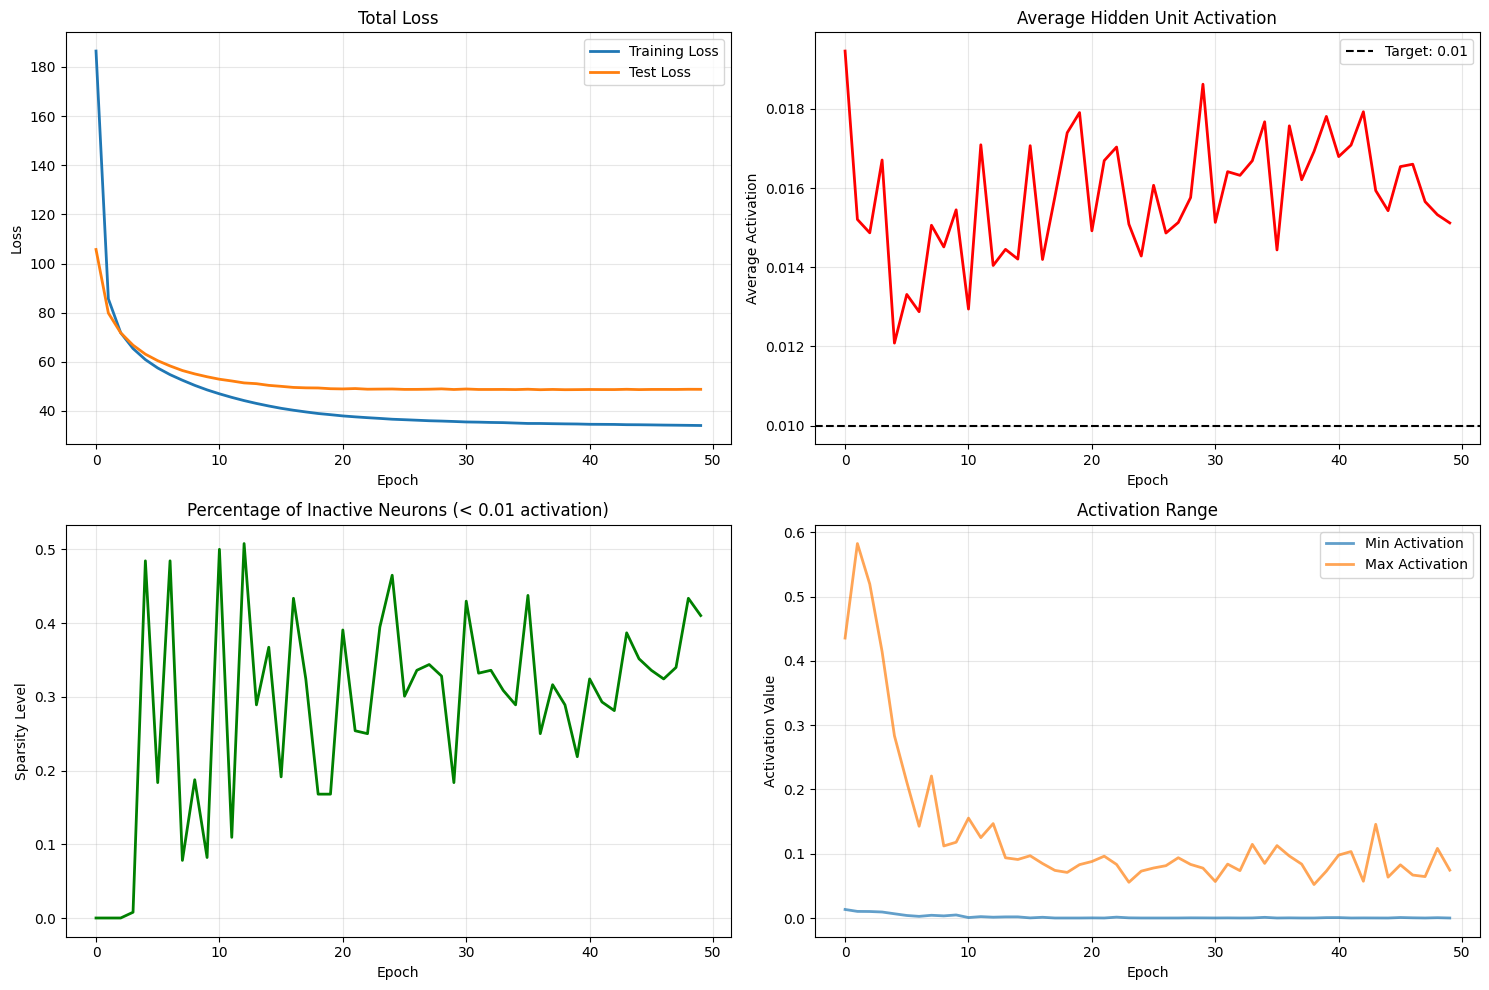

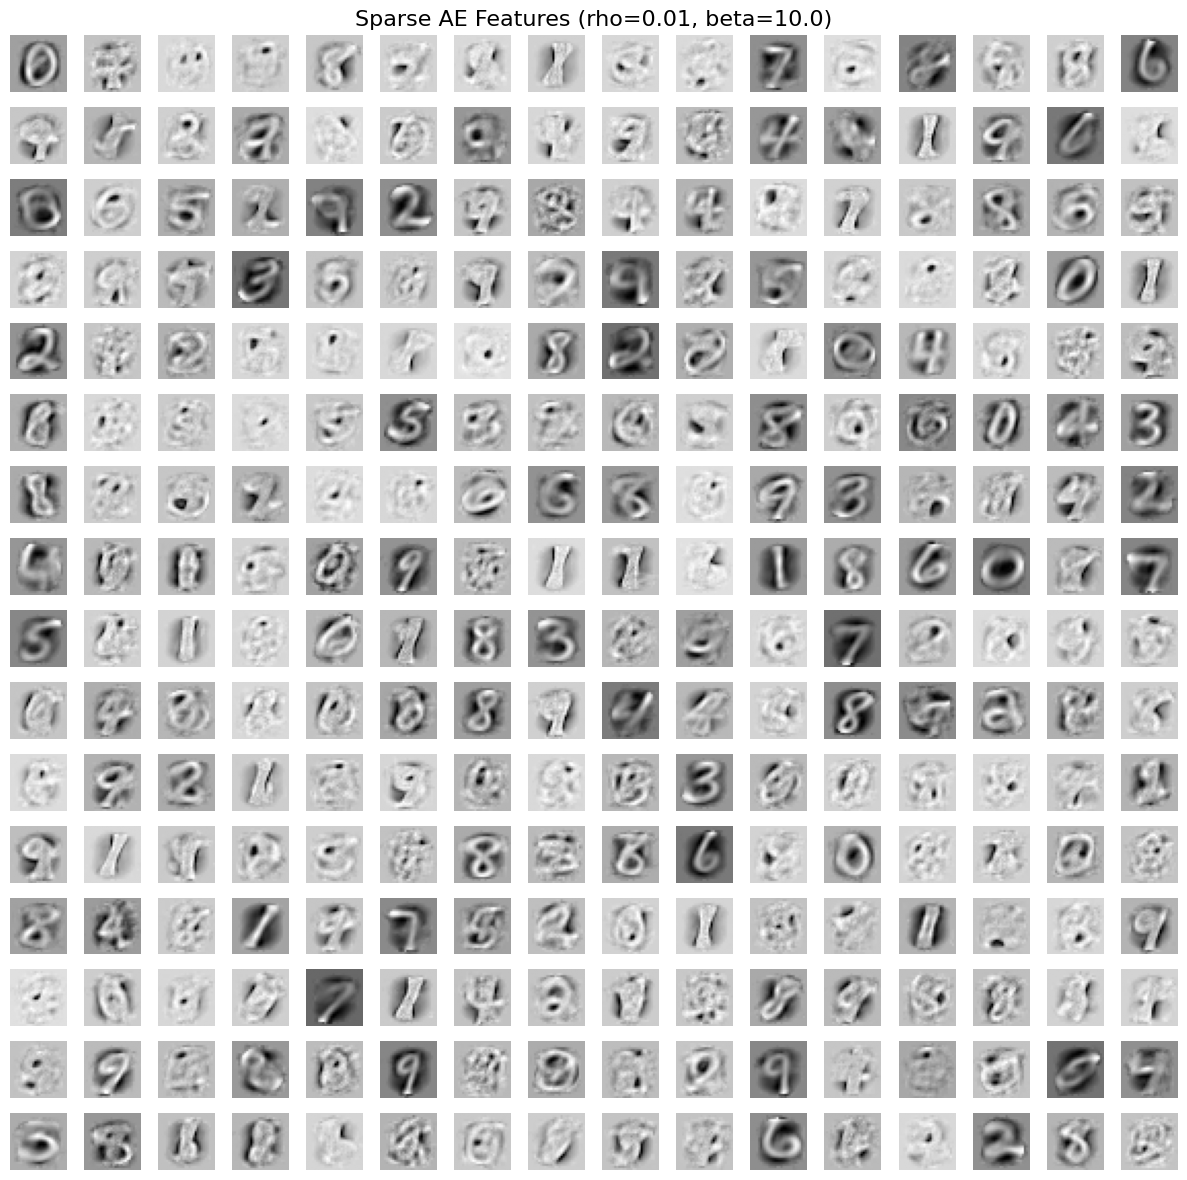


Final Statistics:
  Average Activation: 0.0151 (target: 0.01)
  Sparsity Level: 41.02%
  Final Test Loss: 48.8119

Training with sparsity_param=0.05, beta=1.0
Starting Sparse Autoencoder Training...
Target sparsity: 0.05
Sparsity weight (beta): 1.0
Weight decay (lambda): 0.0001


Epoch 1/50: 100%|██████████| 469/469 [00:10<00:00, 43.87it/s, Total=37.1649, Recon=27.8552, Sparse=9.1304]


Epoch 1:
  Total Loss: 60.2964 | Test Loss: 37.7343
  Recon: 43.9907 | Sparse: 16.1671 | WD: 0.1386
  Avg Activation: 0.1144 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 2/50: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s, Total=28.7243, Recon=23.1768, Sparse=5.2884]


Epoch 2:
  Total Loss: 31.4387 | Test Loss: 28.5835
  Recon: 24.2645 | Sparse: 6.9549 | WD: 0.2193
  Avg Activation: 0.0903 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 3/50: 100%|██████████| 469/469 [00:10<00:00, 46.01it/s, Total=23.7576, Recon=19.2116, Sparse=4.2061]


Epoch 3:
  Total Loss: 24.9492 | Test Loss: 24.1347
  Recon: 19.3124 | Sparse: 5.3372 | WD: 0.2995
  Avg Activation: 0.0868 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 4/50: 100%|██████████| 469/469 [00:10<00:00, 46.78it/s, Total=19.8575, Recon=15.2212, Sparse=4.2153]


Epoch 4:
  Total Loss: 21.3783 | Test Loss: 21.4598
  Recon: 16.5543 | Sparse: 4.4433 | WD: 0.3806
  Avg Activation: 0.0914 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 5/50: 100%|██████████| 469/469 [00:10<00:00, 45.07it/s, Total=19.5584, Recon=15.4748, Sparse=3.5824]


Epoch 5:
  Total Loss: 19.0806 | Test Loss: 19.6326
  Recon: 14.7575 | Sparse: 3.8617 | WD: 0.4613
  Avg Activation: 0.0870 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 6/50: 100%|██████████| 469/469 [00:10<00:00, 44.27it/s, Total=17.4690, Recon=13.1555, Sparse=3.7341]


Epoch 6:
  Total Loss: 17.4629 | Test Loss: 18.3243
  Recon: 13.4698 | Sparse: 3.4524 | WD: 0.5407
  Avg Activation: 0.0891 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 7/50: 100%|██████████| 469/469 [00:10<00:00, 45.61it/s, Total=15.3028, Recon=11.0848, Sparse=3.5634]


Epoch 7:
  Total Loss: 16.2747 | Test Loss: 17.3619
  Recon: 12.4970 | Sparse: 3.1602 | WD: 0.6175
  Avg Activation: 0.0890 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 8/50: 100%|██████████| 469/469 [00:10<00:00, 43.80it/s, Total=14.6718, Recon=10.9921, Sparse=2.9544]


Epoch 8:
  Total Loss: 15.3554 | Test Loss: 16.6069
  Recon: 11.7521 | Sparse: 2.9127 | WD: 0.6906
  Avg Activation: 0.0811 (target: 0.05)
  Sparsity Level: 0.00% neurons < 0.01 activation



Epoch 9/50:  90%|████████▉ | 422/469 [00:09<00:01, 42.85it/s, Total=14.3918, Recon=10.8728, Sparse=2.7344]

In [ ]:
def main():
    """Main function to run sparse autoencoder experiments"""

    # Prepare data
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Experiment with different sparsity parameters
    sparsity_params = [0.01, 0.05, 0.1]
    beta_values = [1.0, 3.0, 10.0]

    for sparsity_param in sparsity_params:
        for beta in beta_values:
            print(f"\n{'='*60}")
            print(f"Training with sparsity_param={sparsity_param}, beta={beta}")
            print(f"{'='*60}")

            # Initialize sparse autoencoder
            sparse_ae = SparseAutoencoder(
                input_dim=784,
                hidden_dim=256,
                sparsity_param=sparsity_param,
                beta=beta,
                lamda=0.0001
            )

            # Train
            train_losses, test_losses, sparsity_stats = train_sparse_autoencoder(
                sparse_ae, train_loader, test_loader,
                epochs=50,  # Reduced for demonstration
                learning_rate=0.001
            )

            # Plot results
            plot_training_progress(train_losses, test_losses, sparsity_stats)

            # Visualize learned features
            visualize_learned_features(sparse_ae,
                f"Sparse AE Features (rho={sparsity_param}, beta={beta})")

            # Show final statistics
            final_stats = sparsity_stats[-1]
            print(f"\nFinal Statistics:")
            print(f"  Average Activation: {final_stats['avg_activation']:.4f} (target: {sparsity_param})")
            print(f"  Sparsity Level: {final_stats['sparsity_level']:.2%}")
            print(f"  Final Test Loss: {test_losses[-1]:.4f}")

if __name__ == "__main__":
    main()